# Comparison of h-h and h-$\Lambda$ 2D Correlations
### using THnSparse methods
### Ravi Koka

Use `python-modules` kernel from the global AliPhysics installation. Additionally, ssh into `/broad/` so VSCode activates the .env file. 

In [1]:
import ROOT as rt
import numpy as np
import matplotlib.pyplot as plt
# from enum import Enum

rt.gStyle.SetOptFit(1111) # show fit panel w/ fit prob, chi2/ndf, fit params, errors

from SparseAnalyzer import SparseAnalyzer #, FitFunction, FitRange, CurveFit
from formatting import process_pave, process_tgraph, process_hist

# magic for autoreloading modules, useful if import function from another Python file
%load_ext autoreload
%autoreload 2
%aimport -CurveFit # don't autoreload CurveFit because enum is comparison will not work
from CurveFit import FitFunction, FitRange, CurveFit

# cool library, need perm to install
# import hist
# https://hist.readthedocs.io/en/latest/user-guide/notebooks/Plots.html

Welcome to JupyROOT 6.26/10


In [2]:
# NOTES
# SetRangeUser is equivalent to SetRange(FindBin)
# SetRangeUser and FindBin will default to right if number is on bin edge, subtract off small amt to be careful
# hist = thn.Project(0).Clone('name') 
#   gives new string name that ROOT uses (you'll see it in top right corner)
#   need to be careful abt string name, if it gets copied to another object, can go wrong (ex. if set SetRangeUser to original bounds)
# can also use: hist.SetName()
# to reset range use SetRangeUser(0, 0)


# look at how delta eta changes given a pT cut
# check how eta ranges match bin edges
# ADD ASSERT STATEMENTS !!

# dist.GetAxis(axis['trigger eta']).SetRangeUser(-0.8, 0.8)

# if increase pT range, expect 2D corr to get sharper
# can also get more triangular del eta if mess with pT or eta i forgor
#   corr two finite random variables = triangle

# stack vs heap
# https://courses.engr.illinois.edu/cs225/fa2022/resources/stack-heap/#:~:text=stack%20%3A%20stores%20local%20variables,stores%20the%20code%20being%20executed

# binning: https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule


#away side / near side (widths) for different cuts and same particle species
#    + div by near side to normalize pT

#do widths ratio for near side
#can try smaller acceptance

#broad can indicate medium intrxn

#if L show diff broadening then hadron, then if we have two diff detector cuts we might not catch it. 

#could mimic broadening (randomly kick particle)

#look into HIJING 

#in PYTHIA, seeing more or less should not effect width of spray

#9/29
#why are tpaves not saving correctly on png
#why is setrangeuser not working for TGraphErrors
#find ryans hard probes talks

#useful: https://cms-opendata-workshop.github.io/workshop2022-lesson-physics-objects/06-substructure/index.html#:~:text=The%20mass%20of%20a%20jet,hadrons%20that%20formed%20the%20jet.

#periodic boundary conditions on delta phi
# important: if i make a hist and then do cuts on original hist, will hist change? will integration change? 

# check that uncerts were calc correctly

# to do
1. Refactor SparseAnalyzer
    - maybe subclass to make fits
    - look into using `__call__`
    - can combine all away- and near-side fits into one method that gets fed an argument to determine the fit function
        - would reduce lines of code
        - also, add way to extract fit params from these
    - add `__str__` method
2. Add more comments to code
3. add normalization option to SparseAnalyzer.make_delta_phi()
4. Clean up
    - delete fitting methods from SparseAnalyzer
    - delete old code
    - delete old fits

## Import the Data

In [3]:
# magic for interactive ROOT plots
%jsroot

In [4]:
# load the ROOT file
inFile = rt.TFile.Open("analysisMultiFine.root")

In [5]:
# load single particle histograms, TH3D
#   axes are: pT, phi, eta
allParticleDist = inFile.allParticleDist
chargedHadronDist = inFile.chargedHadronDist
lambdaDist = inFile.lambdaDist
triggeredLambdaDist = inFile.triggeredLambdaDist

# load correlation dists, 6D THnSparse 
#   axes are: trigger eta, associated eta, trigger pt, associated pt, delta phi, delta eta
hlDist = inFile.hLambdaDist
hhDist = inFile.hhDist

In [6]:
def make_projection_plots(sparse):
    '''
    Makes 1D histograms of quantities from THnSparse, and 2D delta phi delta eta correlation. 
    No single particle cuts applied in this function. 

    Args
        sparse (SparseAnalyzer):
    
    Returns
        canvas (TCanvas): 
    '''

    # project to make 1D hists
    trigEta = sparse.make_1D_hist('trigger eta')
    assocEta = sparse.make_1D_hist('associate eta')
    trigPt = sparse.make_1D_hist('trigger pT')
    assocPt = sparse.make_1D_hist('associate pT')
    dEta = sparse.make_1D_hist('delta eta') 

    # project into 2D correlations and delta eta dist
    dPhiDEta = sparse.make_2D_correlation()
    #dEta = dPhiDEta.ProjectionY()

    # make canvas
    rt.gStyle.SetOptStat(11)
    canvas = rt.TCanvas(f'{sparse.name}_plots_canvas', f'{sparse.name}_plots')
    canvas.SetCanvasSize(1800, 800)
    canvas.Divide(3, 2)

    canvas.cd(1)
    process_hist(trigEta)
    trigEta.GetYaxis().SetRangeUser(0, 1.3*trigEta.GetMaximum())
    trigEta.SetTitle('Trigger #eta')
    trigEta.SetXTitle('#eta')
    trigEta.SetYTitle('counts')
    trigEta.Draw('COLZ')


    canvas.cd(2)
    process_hist(assocEta)
    assocEta.SetTitle('Associate #eta')
    assocEta.SetXTitle('#eta')
    assocEta.SetYTitle('counts')
    assocEta.Draw('COLZ')


    canvas.cd(3)
    process_hist(trigPt)
    trigPt.SetTitle('Trigger p_{T}')
    trigPt.SetXTitle('p_{T}')
    trigPt.SetYTitle('counts')
    trigPt.Draw('COLZ')


    canvas.cd(4)
    process_hist(assocPt)
    assocPt.SetTitle('Associate p_{T}')
    assocPt.SetXTitle('p_{T}')
    assocPt.SetYTitle('counts')
    assocPt.Draw('COLZ')


    canvas.cd(5)
    process_hist(dPhiDEta)
    dPhiDEta.SetTitle('Correlation')
    dPhiDEta.SetXTitle('#Delta#varphi')
    dPhiDEta.SetYTitle('#Delta#eta')
    dPhiDEta.GetYaxis().SetRangeUser(-1.2, 1.199)
    dPhiDEta.Draw('SURF1')


    canvas.cd(6)
    process_hist(dEta)
    dEta.SetTitle('#Delta#eta')
    dEta.SetXTitle('#Delta#eta')
    dEta.SetYTitle('counts')
    dEta.Draw()    

    return canvas

In [7]:
eps = 0.0001

hh = SparseAnalyzer(hhDist, name='hh', apply_cut=False)
hh08 = SparseAnalyzer(hhDist, name='hh08', etaAssoc=[-0.8, 0.8-eps], apply_cut=True)
hh12 = SparseAnalyzer(hhDist, name='hh12', etaAssoc=[-1.2, 1.2-eps], apply_cut=True)
hh20 = SparseAnalyzer(hhDist, name='hh20', etaAssoc=[-2.0, 2.0-eps], apply_cut=True)

hl = SparseAnalyzer(hlDist, name='hl', apply_cut=False)
hl08 = SparseAnalyzer(hlDist, name='hl08', etaAssoc=[-0.8, 0.8-eps], apply_cut=True)
hl12 = SparseAnalyzer(hlDist, name='hl12', etaAssoc=[-1.2, 1.2-eps], apply_cut=True)
hl20 = SparseAnalyzer(hlDist, name='hl20', etaAssoc=[-2.0, 2.0-eps], apply_cut=True)

In [8]:
distributions = [hh, hh08, hh12, hh20, hl, hl08, hl12, hl20]

In [9]:
canvases = []
for dist in distributions:
    canvases.append(make_projection_plots(dist))

In [10]:
c1, c2, c3, c4, c5, c6, c7, c8 = canvases

## $\Delta\varphi$ Widths

In [11]:
# standard gaussian fit

dir = '/home/ravikkoka/alice/broad/plots/'

dPhiCanvas = rt.TCanvas('dphi_canvas', 'dphi_canvas')

dPhiCanvas.SetCanvasSize(2400, 800)
dPhiCanvas.Divide(4, 2)

guesses = [[18000, 1, 4000, 1], [20000, 1, 8000, 1], [20000, 1, 15000, 1], [20000, 1, 20000, 1],
           [200, 1, 800, 1], [100, 1, 150, 1], [100, 0.19, 250, 1], [100, 1, 400, 1]]
awayStDev = np.zeros(shape=(len(distributions), 2))
nearStDev = np.zeros(shape=(len(distributions), 2))
for i, (sparse, guess) in enumerate(zip(distributions, guesses)):
    dPhiCanvas.cd(i + 1)

    dPhi = sparse.make_delta_phi()
    dPhi, params = sparse.fit_delta_phi(dPhi, guess, ratio_plot=False)
    
    nearStDev[i] = params[2]
    awayStDev[i] = params[5]

    pave = sparse.make_pave()    
    dPhi.Draw()
    pave.Draw()
        
dPhiCanvas.SaveAs(dir + 'delta_phi_plots.png')
dPhiCanvas.Draw()

 FCN=3109.89 FROM MIGRAD    STATUS=CONVERGED     222 CALLS         223 TOTAL
                     EDM=1.03958e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.2 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.82459e+04   1.70927e+02   7.53358e-01  -4.69628e-06
   2  p1           0.00000e+00     fixed    
   3  p2          -1.84284e-01   5.50758e-04   2.70471e-06   8.49029e-01
   4  p3           2.33132e+04   9.60174e+01  -1.39567e-01  -2.41060e-06
   5  p4           3.14159e+00     fixed    
   6  p5           3.60652e-01   9.96697e-04  -6.21872e-07  -1.35764e+00
 FCN=864.367 FROM MIGRAD    STATUS=CONVERGED     278 CALLS         279 TOTAL
                     EDM=1.71206e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.3 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DE

Info in <TCanvas::Print>: png file /home/ravikkoka/alice/broad/plots/delta_phi_plots.png has been created


In [12]:
# general gaussian fit
dir = '/home/ravikkoka/alice/broad/plots/'

dPhiCanvas = rt.TCanvas('dphi_canvas', 'dphi_canvas')

dPhiCanvas.SetCanvasSize(2400, 800)
dPhiCanvas.Divide(4, 2)

guesses = [[0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1],
           [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1]]

awayStDev = np.zeros(shape=(len(distributions), 2))
nearStDev = np.zeros(shape=(len(distributions), 2))
for i, (sparse, guess) in enumerate(zip(distributions, guesses)):
    dPhiCanvas.cd(i + 1)

    dPhi = sparse.make_delta_phi()
    dPhi, params = sparse.fit_gen_gaussian(dPhi, guess)
    
    nearStDev[i], awayStDev[i] = sparse.calc_gen_gaussian_widths(params) 

    dPhi.Draw()
    pave.Draw()
        
dPhiCanvas.SaveAs(dir + 'delta_phi_plots_general.png')
dPhiCanvas.Draw()

NotImplementedError: Implement uncertainties

 FCN=809.798 FROM MIGRAD    STATUS=CONVERGED     575 CALLS         576 TOTAL
                     EDM=1.545e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   5.7 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           0.00000e+00     fixed    
   2  p1           2.28421e-01   1.60534e-03  -3.26083e-07  -6.67922e-01
   3  p2           1.61901e+00   1.25291e-02   1.65924e-05   5.43631e-02
   4  p3           1.80041e+04   6.07506e+01  -1.12969e-01   7.42449e-06
   5  p4           3.14159e+00     fixed    
   6  p5           4.28577e-01   2.64335e-03   2.49900e-06  -1.53720e-01
   7  p6           1.47829e+00   1.05437e-02   3.32421e-05   1.56689e-02
   8  p7           2.14531e+04   6.53169e+01  -1.78359e-01   2.54602e-06


Warning in <TCanvas::Constructor>: Deleting canvas with same name: dphi_canvas


In [13]:
# plot ratio of yields in near side and away side, for same type of correlation
widthsNearOverAwayCanvas = rt.TCanvas()
widthsNearOverAwayCanvas.SetCanvasSize(800, 400)

# get rid of ratios for distributions with no eta cuts
filter = [False, True, True, True, 
          False, True, True, True]

nearStDev = nearStDev[filter]
awayStDev = awayStDev[filter]

# get widths for h-h azimuthal correlations
hhAwayWidths = awayStDev[:3, 0]
hhNearWidths = nearStDev[:3, 0]
hhAwayErrs = awayStDev[:3, 1]
hhNearErrs = nearStDev[:3, 1]

# get widths for h-Lambda azimuthal correlations
hlAwayWidths = awayStDev[3:, 0]
hlNearWidths = nearStDev[3:, 0]
hlAwayErrs = awayStDev[3:, 1]
hlNearErrs = nearStDev[3:, 1]

# typical error propagation for ratio
errorProp = lambda x, xerr, y, yerr: (x / y) * np.sqrt((xerr / x)**2 + (yerr / y)**2)

# calc h-h near side width / h-h away side width
# hhRatios = hhNearWidths / hhAwayWidths
# hhErrs = errorProp(hhNearWidths, hhNearErrs, hhAwayWidths, hhAwayErrs)
hhRatios = hhAwayWidths / hhNearWidths
hhErrs = errorProp(hhAwayWidths, hhAwayErrs, hhNearWidths, hhNearErrs)

# calc h-Lambda near side width / h-h near side width
# hlRatios = hlNearWidths / hlAwayWidths
# hlErrs = errorProp(hlNearWidths, hlNearErrs, hlAwayWidths, hlAwayErrs)
hlRatios = hlAwayWidths / hlNearWidths
hlErrs = errorProp(hlAwayWidths, hlAwayErrs, hlNearWidths, hlNearErrs)

# calc h-Lambda away side width / h-h away side width
widthRatios = hlAwayWidths / hhAwayWidths
ratioErrs = errorProp(hlAwayWidths, hlAwayErrs, hhAwayWidths, hhAwayErrs)
# ratioErrs = widthRatios * np.sqrt(1 / hlAwayWidths + 1 / hhAwayWidths)

print(widthRatios, ratioErrs)

etaAxis = np.array([0.8, 1.2, 2.0], dtype='d')
etaErrs = np.zeros(len(etaAxis))

[nan nan nan] [nan nan nan]


<ipython-input-13-93f01192a492>:30: RuntimeWarning: invalid value encountered in true_divide
  hhRatios = hhAwayWidths / hhNearWidths
<ipython-input-13-93f01192a492>:25: RuntimeWarning: invalid value encountered in true_divide
  errorProp = lambda x, xerr, y, yerr: (x / y) * np.sqrt((xerr / x)**2 + (yerr / y)**2)
<ipython-input-13-93f01192a492>:36: RuntimeWarning: invalid value encountered in true_divide
  hlRatios = hlAwayWidths / hlNearWidths
<ipython-input-13-93f01192a492>:40: RuntimeWarning: invalid value encountered in true_divide
  widthRatios = hlAwayWidths / hhAwayWidths


In [14]:
widthRatiosCanvas = rt.TCanvas('widthRatiosCanvas', 'widthRatiosCanvas')
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)

widthRatiosPave = rt.TPaveText(0.5, 0.760593, 0.899425, 0.860169, 'NDC')
widthRatiosPave.AddText('pp, PYTHIA6, #sqrt{s}=14 TeV')
widthRatiosPave.AddText('4 < p_{T}^{trig} < 8 GeV/c, 2 < p_{T}^{assoc} < 4 GeV/c')
widthRatiosPave.AddText('|#eta^{trig}| < 0.8')
#widthRatiosPave = 
process_pave(widthRatiosPave, size=0.06)


widthRatiosGraph = rt.TGraphErrors(len(widthRatios), etaAxis, widthRatios, ex=etaErrs, ey=ratioErrs)
widthRatiosGraph.SetMarkerStyle(107)

widthRatiosGraph.SetTitle('Away-side Width Ratio per #eta cut')
#widthRatiosGraph.GetYaxis().SetTitle('Width Ratio #left(#frac{h-#Lambda}{h-h}#right)')
widthRatiosGraph.GetYaxis().SetTitle('#sigma^{h-#Lambda}_{AS} / #sigma^{h-h}_{AS}')
widthRatiosGraph.GetXaxis().SetTitle('|#eta^{assoc}| < x')

process_tgraph(widthRatiosGraph)

widthRatiosGraph.GetYaxis().SetRangeUser(0.8, 1.2)
#widthRatiosGraph.GetYaxis().LabelsOption('v')

line = rt.TLine(0.68, 1.0, 2.12, 1.0)
line.SetLineColor(4)
line.SetLineStyle(2)
line.SetLineWidth(2)

widthRatiosGraph.Draw('ap')
widthRatiosPave.Draw()
line.Draw()
widthRatiosCanvas.Draw()
#widthRatiosCanvas.SaveAs('plots/away_side_width_ratios.png')

In [15]:
nsWidthRatiosCanvas = rt.TCanvas('nsWidthRatiosCanvas', 'nsWidthRatiosCanvas')
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)

nsWidthRatios = hlNearWidths / hhAwayWidths
nsWidthErrs = errorProp(hlNearWidths, hlNearErrs, hhNearWidths, hhNearErrs)

nsWidthRatiosGraph = rt.TGraphErrors(len(etaAxis), etaAxis, nsWidthRatios, ex=etaErrs, ey=nsWidthErrs)
nsWidthRatiosGraph.SetMarkerStyle(21)
nsWidthRatiosGraph.SetMarkerColor(4)
nsWidthRatiosGraph.SetLineColor(4)

nsWidthRatiosGraph.SetTitle('Near-side Width Ratio per #eta cut')
nsWidthRatiosGraph.GetYaxis().SetTitle('#sigma^{h-#Lambda}_{NS} / #sigma^{h-h}_{NS}')
nsWidthRatiosGraph.GetXaxis().SetTitle('|#eta^{assoc}| < x')

process_tgraph(nsWidthRatiosGraph)
nsWidthRatiosGraph.SetMaximum(0.8)
nsWidthRatiosGraph.SetMinimum(0.2)

nsWidthRatiosGraph.Draw('p')
widthRatiosPave.Draw()
nsWidthRatiosCanvas.Draw()

<ipython-input-15-be77c6c4f408>:5: RuntimeWarning: invalid value encountered in true_divide
  nsWidthRatios = hlNearWidths / hhAwayWidths
<ipython-input-13-93f01192a492>:25: RuntimeWarning: invalid value encountered in true_divide
  errorProp = lambda x, xerr, y, yerr: (x / y) * np.sqrt((xerr / x)**2 + (yerr / y)**2)


In [16]:
hhRatiosCanvas = rt.TCanvas()
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)

hhRatiosPave = widthRatiosPave.Clone()

hhRatiosGraph = rt.TGraphErrors(len(hhRatios), etaAxis, hhRatios, ex=etaErrs, ey=hhErrs)
hhRatiosGraph.SetTitle('h-h Width Ratios per #eta Cut')
#hhRatiosGraph.GetYaxis().SetTitle('h-h Width Ratios #left(#frac{NS}{AS}#right)')
hhRatiosGraph.GetYaxis().SetTitle('#sigma^{h-h}_{AS} / #sigma^{h-h}_{NS}')
hhRatiosGraph.GetXaxis().SetTitle('|#eta^{assoc}| < x')

hhRatiosGraph.SetMarkerStyle(20)
hhRatiosGraph.SetMarkerColor(2)
hhRatiosGraph.SetLineColor(2)
#hhRatiosGraph.GetYaxis().SetRangeUser(0.48, 0.62)
#hhRatiosGraph.GetXaxis().CenterTitle(True)
#hhRatiosGraph.GetYaxis().CenterTitle(True)
#hhRatiosGraph.GetXaxis().SetTitleOffset(1.4)
#hhRatiosGraph.GetYaxis().SetTitleOffset(1.4)

process_tgraph(hhRatiosGraph)

hhRatiosGraph.SetMinimum(0)
hhRatiosGraph.SetMaximum(2.3)


hhRatiosGraph.Draw('ap')
hhRatiosPave.Draw()
hhRatiosCanvas.Draw()

In [17]:
hlRatiosCanvas = rt.TCanvas()
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)

hlRatiosPave = widthRatiosPave.Clone()

hlRatiosGraph = rt.TGraphErrors(len(hlRatios), etaAxis, hlRatios, ex=etaErrs, ey=hlErrs)
hlRatiosGraph.SetTitle('h-#Lambda width ratios per #eta cut')
hlRatiosGraph.GetXaxis().SetTitle('|#eta^{assoc}| < x')
#hlRatiosGraph.GetYaxis().SetTitle('h-#Lambda Width Ratios #left(#frac{NS}{AS}#right)')
hlRatiosGraph.GetYaxis().SetTitle('#sigma^{h-#Lambda}_{AS} / #sigma^{h-#Lambda}_{NS}')

process_tgraph(hlRatiosGraph)

hlRatiosGraph.SetMinimum(0.0)
hlRatiosGraph.SetMaximum(2.5)



hlRatiosGraph.SetMarkerStyle(21)
hlRatiosGraph.Draw('ap')
hlRatiosPave.Draw()
hlRatiosCanvas.Draw()

In [18]:
compareRatiosCanvas = rt.TCanvas()
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)

widthsMultiGraph = rt.TMultiGraph('widthmg', 'widthmg')

#hhRatiosGraph.SetMarkerColor(2)
#hlRatiosGraph.SetMarkerColor(1)

#hhRatiosGraph.SetMarkerStyle(8)
#hlRatiosGraph.SetMarkerStyle(21)


hhRatiosGraph.SetTitle('#sigma^{h-h}_{AS} / #sigma^{h-h}_{NS}')
hlRatiosGraph.SetTitle('#sigma^{h-#Lambda}_{AS} / #sigma^{h-#Lambda}_{NS}')
widthsMultiGraph.Add(hhRatiosGraph, 'p')
widthsMultiGraph.Add(hlRatiosGraph, 'p')


widthsMultiGraph.SetTitle('Comparison of Widths Ratios per #eta Cut')
widthsMultiGraph.GetXaxis().SetTitle('|#eta^{assoc}| < x')
#widthsMultiGraph.GetYaxis().SetTitle('Width Ratios #left(#frac{NS}{AS}#right)')
widthsMultiGraph.GetYaxis().SetTitle('#sigma_{AS} / #sigma_{NS}')
widthsMultiGraph.GetYaxis().SetRangeUser(1.2, 2.5)

process_tgraph(widthsMultiGraph)

widthsMultiGraph.Draw()


legend = compareRatiosCanvas.BuildLegend(0.571839, 0.68644, 0.87212, 0.89618)
legend.SetBorderSize(0)
legend.SetFillStyle(0)
legend.SetTextSize(0.035)

widthsMultiGraphPave = rt.TPaveText(0.5, 0.760593, 0.899425, 0.860169)#0.189655, 0.764830, 0.589080, 0.86440677, 'NDC')
widthsMultiGraphPave.AddText('4 < p_{T}^{trig} < 8 GeV/c, 2 < p_{T}^{assoc} < 4 GeV/c')
widthsMultiGraphPave.AddText('|#eta^{trig}| < 0.8')
widthsMultiGraphPave = process_pave(widthRatiosPave, size=0.06)

# set coordinates of pave and legend, ROOT ignores the previous coords for reasons unknown to me
rt.gPad.Update()
widthsMultiGraphPave.SetX1NDC(0.1896551724137931)
widthsMultiGraphPave.SetY1NDC(0.760593220338983)
widthsMultiGraphPave.SetX2NDC(0.5890804597701149)
widthsMultiGraphPave.SetY2NDC(0.8601694915254238)

legend.SetX1NDC(0.6681034482758621)
legend.SetY1NDC(0.6949152542372881)
legend.SetX2NDC(0.9683908045977011)
legend.SetY2NDC(0.9046610169491526)
rt.gPad.Modified()

widthsMultiGraphPave.Draw()
compareRatiosCanvas.Draw()

## $\Delta \varphi$ Widths for Various Fit Functions

In [9]:
# fit to regular gaussian
distributions = [hh08, hh12, hh20, hl08, hl12, hl20]

c_gaus = rt.TCanvas('gaus_canvas', 'gaus_canvas')
c_gaus.SetCanvasSize(2400, 800)
c_gaus.Divide(3, 2)

c_gen_gaus = rt.TCanvas('gaus_gen_canvas', 'gaus_gen_canvas')
c_gen_gaus.SetCanvasSize(2400, 800)
c_gen_gaus.Divide(3, 2)

c_mises = rt.TCanvas('mises_canvas', 'gaus_mises_canvas')
c_mises.SetCanvasSize(2400, 800)
c_mises.Divide(3, 2)

fit_functions=[FitFunction.double_gaussian, FitFunction.double_generalized_gaussian, FitFunction.double_von_mises]

gaus_params = []
gen_gaus_params = []
mises_params = []

pi = rt.TMath.Pi()
gaus_guesses =[[20000, 0.0, 1, 8000, pi, 1], [20000, 0.0, 1, 15000, pi, 1], [20000, 0.0, 1, 20000, pi, 1],
                [100, 0.0, 1, 150, pi, 1], [100, 0.0, 0.19, 250, pi, 1], [100, 0.0, 1, 400, pi, 1]]

gen_gaus_guesses = [[0.0, 0.7, 1.8, 1, pi, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, pi, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, pi, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, pi, 1, 1.8, 1],
                        [0.0, 0.7, 1.8, 1, pi, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, pi, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, pi, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, pi, 1, 1.8, 1]]

mises_guesses = [[20000, 0.0, 1, 8000, pi, 1], [20000, 0.0, 1, 15000, pi, 1], [20000, 0.0, 30, 20000, pi, 1],
                [100, 0.0, 1, 150, pi, 1], [100, 0.0, 0.19, 250, pi, 1], [100, 0.0, 1, 400, pi, 1]]

for i, (sparse, guess) in enumerate(zip(distributions, gaus_guesses)):
        c_gaus.cd(i + 1) 

        gaussian = CurveFit(sparse=sparse, dphi=sparse.make_delta_phi(), fit_function=FitFunction.double_gaussian, fit_range=FitRange.full_range, fit_params=guess)
        dphi, params = gaussian.fit()
        
        gaus_params.append(params)
        dphi.Draw()

for i, (sparse, guess) in enumerate(zip(distributions, gen_gaus_guesses)):
        c_gen_gaus.cd(i + 1) 

        gen_gaussian = CurveFit(sparse=sparse, dphi=sparse.make_delta_phi(), fit_function=FitFunction.double_generalized_gaussian, fit_range=FitRange.full_range, fit_params=guess)
        dphi, params = gen_gaussian.fit()

        gen_gaus_params.append(params)
        dphi.Draw()

for i, (sparse, guess) in enumerate(zip(distributions, mises_guesses)):
        c_mises.cd(i + 1) 

        mises = CurveFit(sparse=sparse, dphi=sparse.make_delta_phi(), fit_function=FitFunction.double_von_mises, fit_range=FitRange.full_range, fit_params=guess)
        dphi, params = mises.fit()
        mises_params.append(params)
        dphi.Draw()

 FCN=864.367 FROM MIGRAD    STATUS=CONVERGED     266 CALLS         267 TOTAL
                     EDM=4.57393e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.2 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.54928e+04   1.09419e+02   1.67688e+00  -3.82236e-06
   2  p1           0.00000e+00     fixed    
   3  p2           1.81362e-01   8.57292e-04  -4.04277e-06   1.85788e+00
   4  p3           4.50820e+03   4.12983e+01   1.22534e+00   5.85747e-06
   5  p4           3.14159e+00     fixed    
   6  p5           3.69844e-01   2.25238e-03  -7.56083e-06   3.38487e+00
 FCN=1012.64 FROM MIGRAD    STATUS=CONVERGED     313 CALLS         314 TOTAL
                     EDM=6.81227e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   

In [10]:
c_gaus.Draw()

In [11]:
c_gen_gaus.Draw()

In [12]:
c_mises.Draw()

In [13]:
gaus_params = np.array(gaus_params)
gaus_stdev_near = gaus_params[:, 2, 0]
gaus_stdev_away = gaus_params[:, 5, 0]

In [14]:
def gen_gaus_stdev(alpha, beta):
    '''
    Returns the standard deviation of a generalized gaussian, given alpha and beta. 
    '''
    var = alpha**2 * rt.Math.tgamma(3 / beta) / rt.Math.tgamma(1 / beta)
    
    return rt.TMath.Sqrt(var)

gen_gaus_params = np.array(gen_gaus_params)

gen_gaus_params_alpha_near = gen_gaus_params[:, 1, 0]
gen_gaus_params_beta_near = gen_gaus_params[:, 2, 0] 

gen_gaus_params_alpha_away = gen_gaus_params[:, 5, 0]
gen_gaus_params_beta_away = gen_gaus_params[:, 6, 0]

gen_gaus_stdev_near = np.array([gen_gaus_stdev(alpha, beta) for (alpha, beta) in zip(gen_gaus_params_alpha_near, gen_gaus_params_beta_near)])
gen_gaus_stdev_away = np.array([gen_gaus_stdev(alpha, beta) for (alpha, beta) in zip(gen_gaus_params_alpha_away, gen_gaus_params_beta_away)])

In [15]:
def mises_stdev(kappa):
    '''
    Returns the standard deviation of a von mises distribution, given alpha and beta.
    '''
    var = 1 - rt.TMath.BesselI1(kappa) / rt.TMath.BesselI0(kappa)

    return rt.TMath.Sqrt(var)

mises_params = np.array(mises_params)
mises_kappa_near = mises_params[:, 2, 0]
mises_kappa_away = mises_params[:, 5, 0]

mises_stdev_near = np.array([mises_stdev(kappa) for kappa in mises_kappa_near])
mises_stdev_away = np.array([mises_stdev(kappa) for kappa in mises_kappa_away])

In [30]:
plt.rcParams['figure.dpi'] = 400

In [21]:
gaus_stdev_away

array([0.36984438, 0.36810726, 0.36263954, 0.37736159, 0.35993464,
       0.37310455])

In [23]:
np.reshape(gaus_stdev_away, (2, 3))

array([[0.36984438, 0.36810726, 0.36263954],
       [0.37736159, 0.35993464, 0.37310455]])

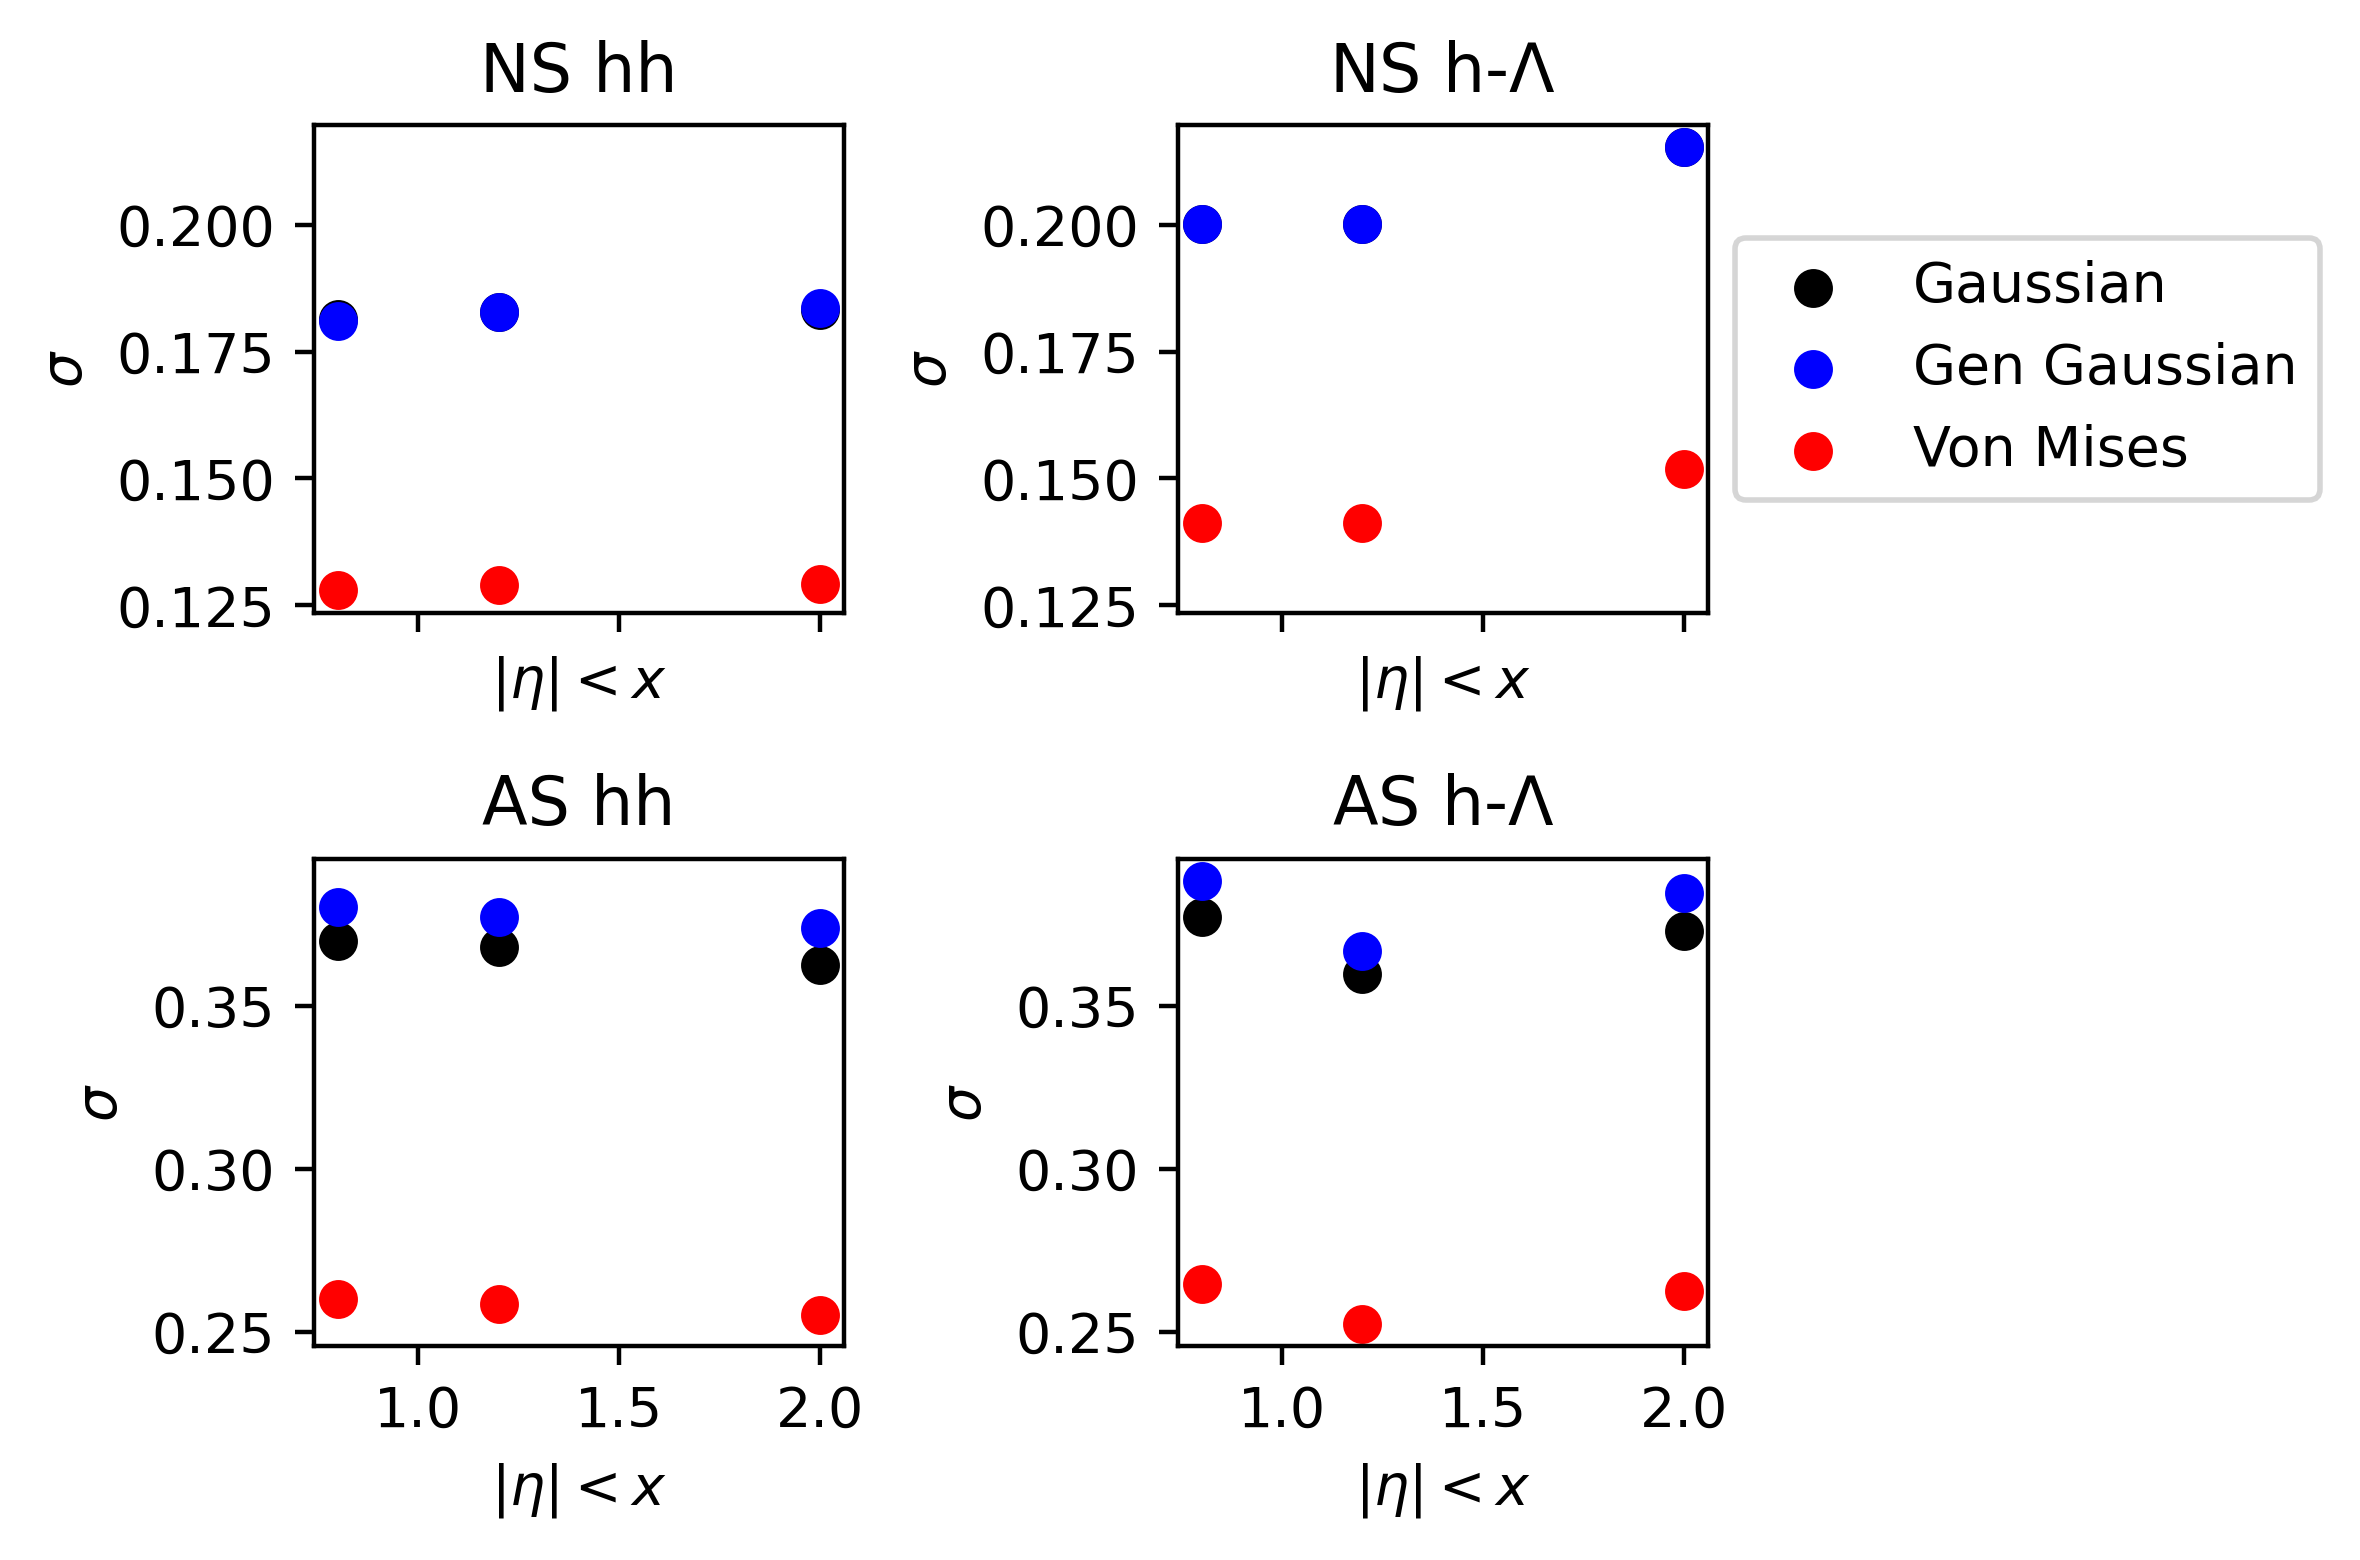

In [56]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True)
ax1.sharey(ax2)
ax3.sharey(ax4)

eta = [0.8, 1.2, 2.0]
ax1.scatter(eta, gaus_stdev_near[:3], color='k')
ax1.scatter(eta, gen_gaus_stdev_near[:3], color='b')
ax1.scatter(eta, mises_stdev_near[:3], color='r')

ax2.scatter(eta, gaus_stdev_near[3:], color='k', label='Gaussian')
ax2.scatter(eta, gen_gaus_stdev_near[3:], color='b', label='Gen Gaussian')
ax2.scatter(eta, mises_stdev_near[3:], color='r',  label='Von Mises')

ax3.scatter(eta, gaus_stdev_away[:3], color='k')
ax3.scatter(eta, gen_gaus_stdev_away[:3], color='b')
ax3.scatter(eta, mises_stdev_away[:3], color='r')

ax4.scatter(eta, gaus_stdev_away[3:], color='k')
ax4.scatter(eta, gen_gaus_stdev_away[3:], color='b')
ax4.scatter(eta, mises_stdev_away[3:], color='r')

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel('$|\eta|<x$')
    ax.set_ylabel('$\sigma$') 

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax1.set_title('NS hh')
ax2.set_title('NS h-$\Lambda$')
ax3.set_title('AS hh')
ax4.set_title('AS h-$\Lambda$')

plt.tight_layout()

<ipython-input-70-42edc0ad5a59>:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


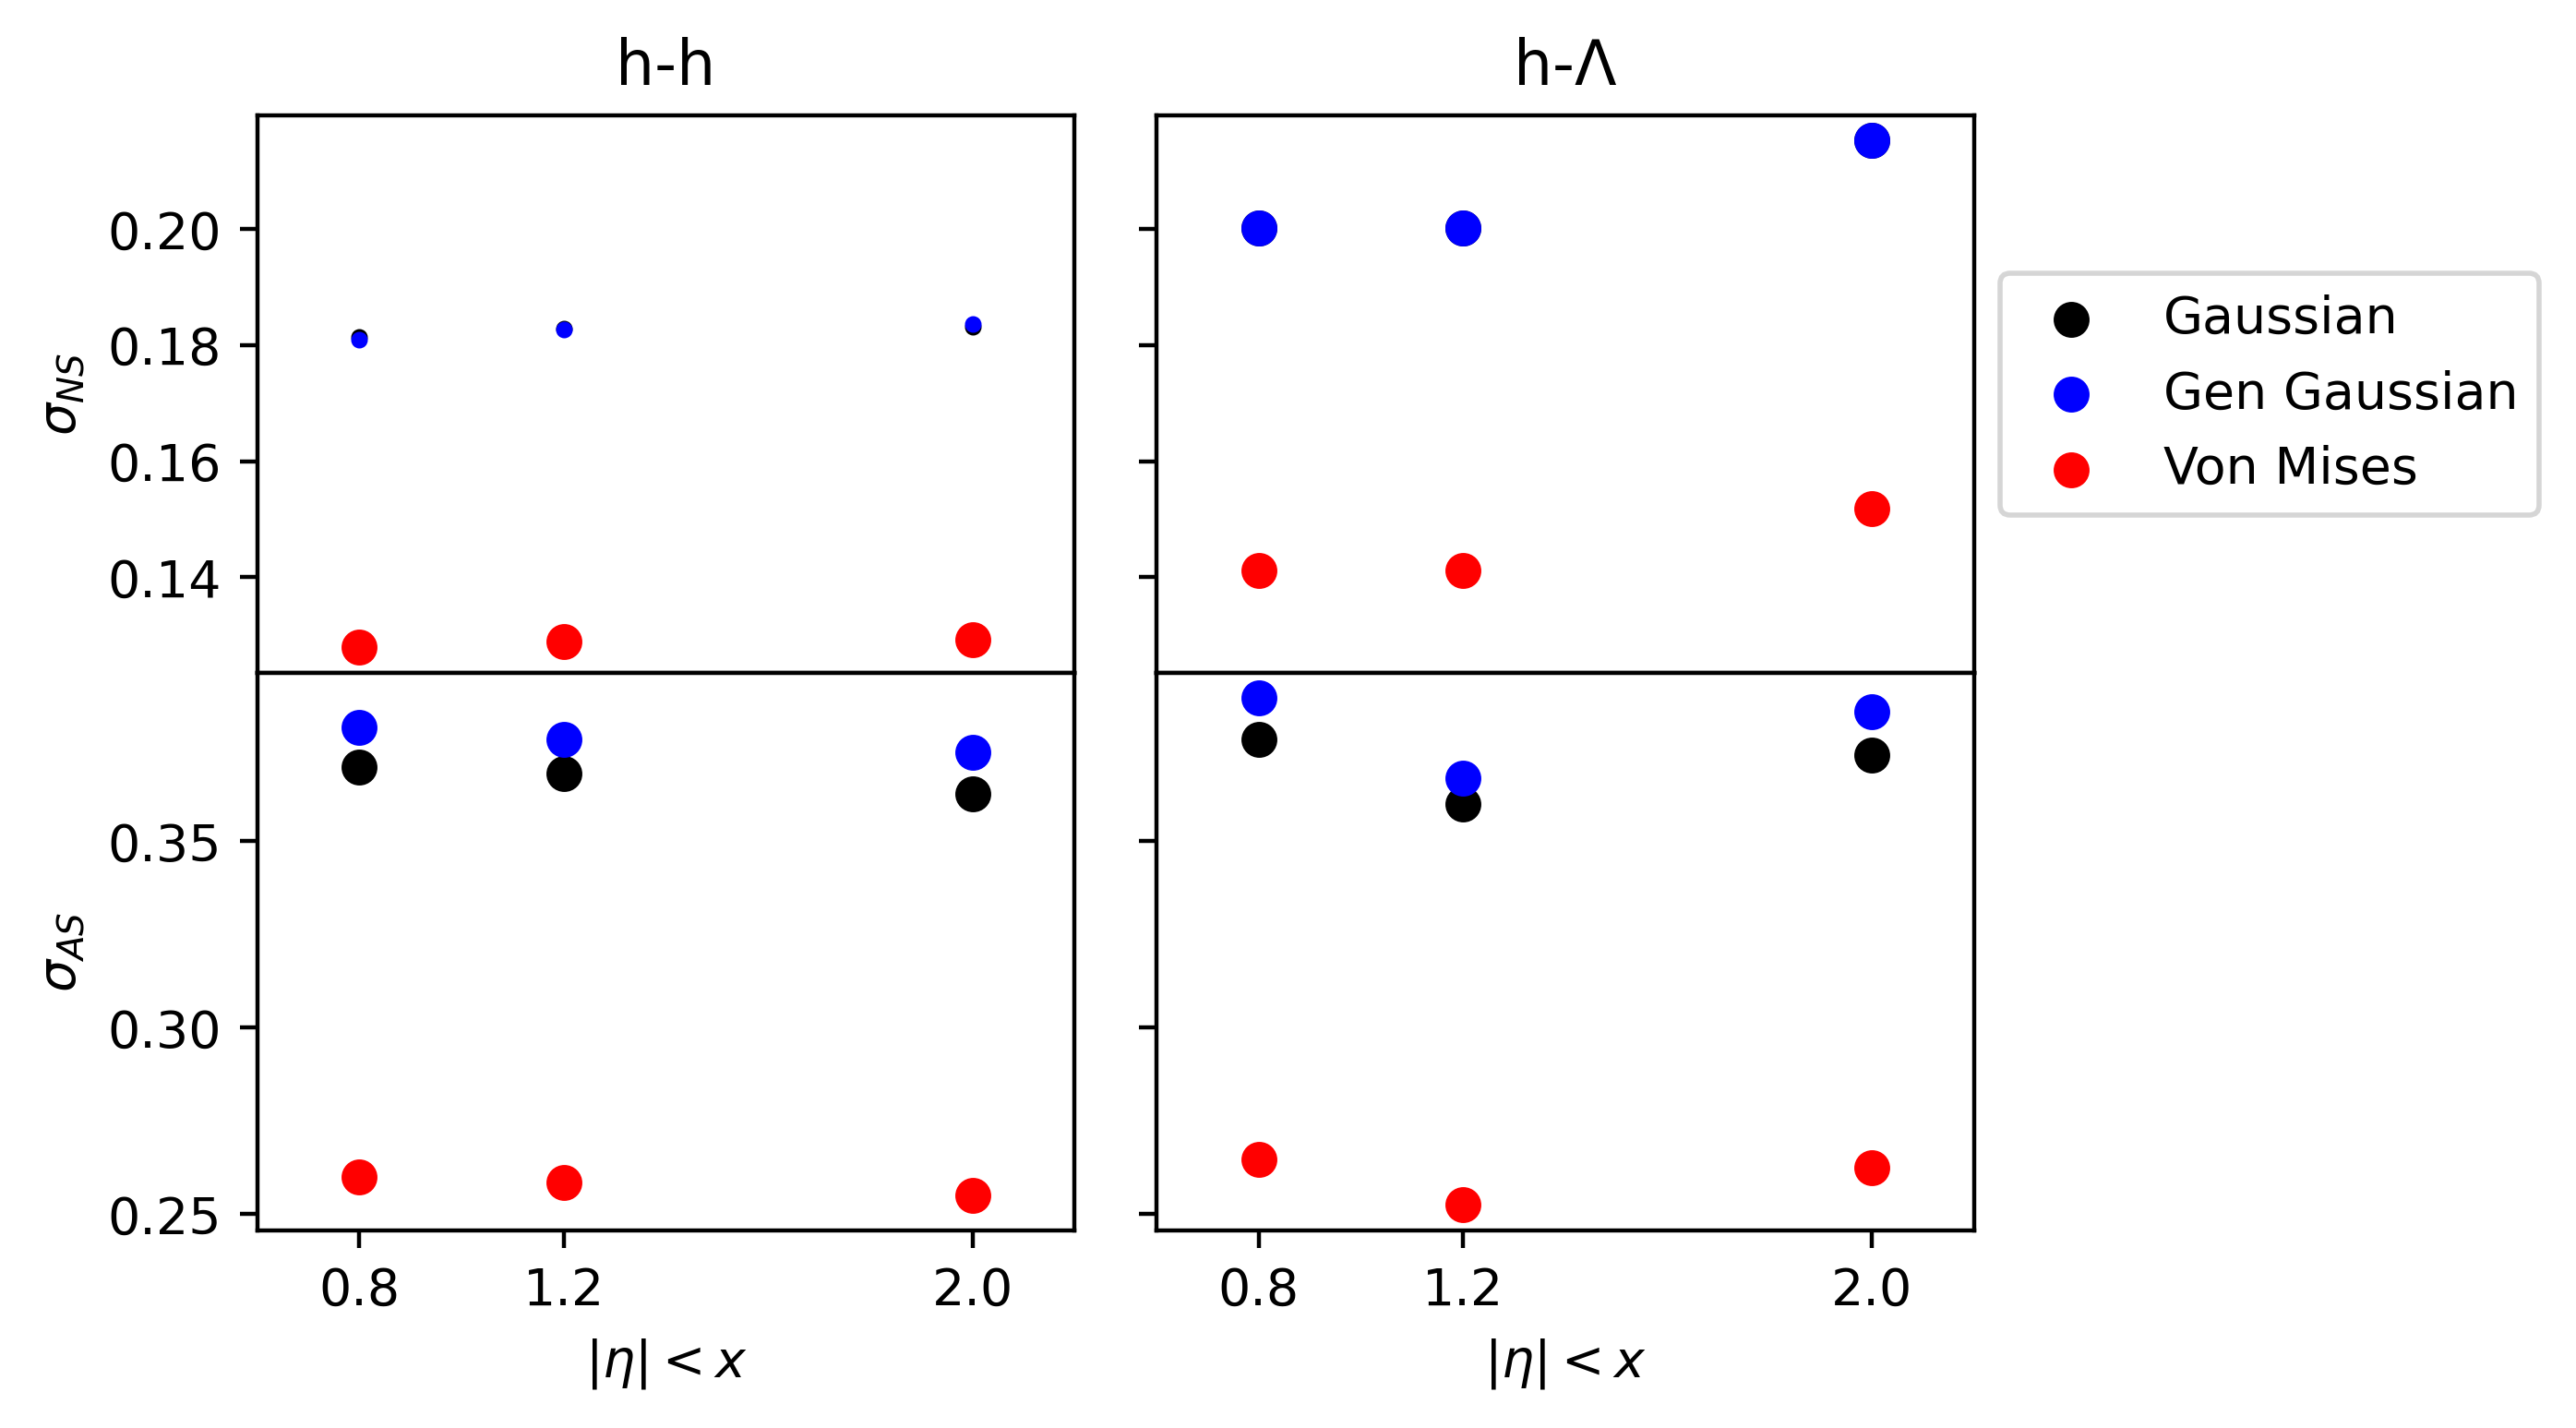

In [70]:
fig = plt.figure()
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0.1)
((ax1, ax2),(ax3, ax4)) = gs.subplots(sharex='col', sharey='row')

eta = [0.8, 1.2, 2.0]
ax1.scatter(eta, gaus_stdev_near[:3], color='k')
ax1.scatter(eta, gen_gaus_stdev_near[:3], color='b')
ax1.scatter(eta, mises_stdev_near[:3], color='r')

ax2.scatter(eta, gaus_stdev_near[3:], color='k', label='Gaussian')
ax2.scatter(eta, gen_gaus_stdev_near[3:], color='b', label='Gen Gaussian')
ax2.scatter(eta, mises_stdev_near[3:], color='r',  label='Von Mises')

ax3.scatter(eta, gaus_stdev_away[:3], color='k')
ax3.scatter(eta, gen_gaus_stdev_away[:3], color='b')
ax3.scatter(eta, mises_stdev_away[:3], color='r')

ax4.scatter(eta, gaus_stdev_away[3:], color='k')
ax4.scatter(eta, gen_gaus_stdev_away[3:], color='b')
ax4.scatter(eta, mises_stdev_away[3:], color='r')

ax3.set_xlim(0.6, 2.2)
ax4.set_xlim(0.6, 2.2)
ax3.set_xticks(eta)
ax4.set_xticks(eta)

ax1.set_ylabel('$\sigma_{NS}$')
ax3.set_ylabel('$\sigma_{AS}$')

ax3.set_xlabel('$|\eta|<x$')
ax4.set_xlabel('$|\eta|<x$')

ax1.set_title('h-h')
ax2.set_title('h-$\Lambda$')

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

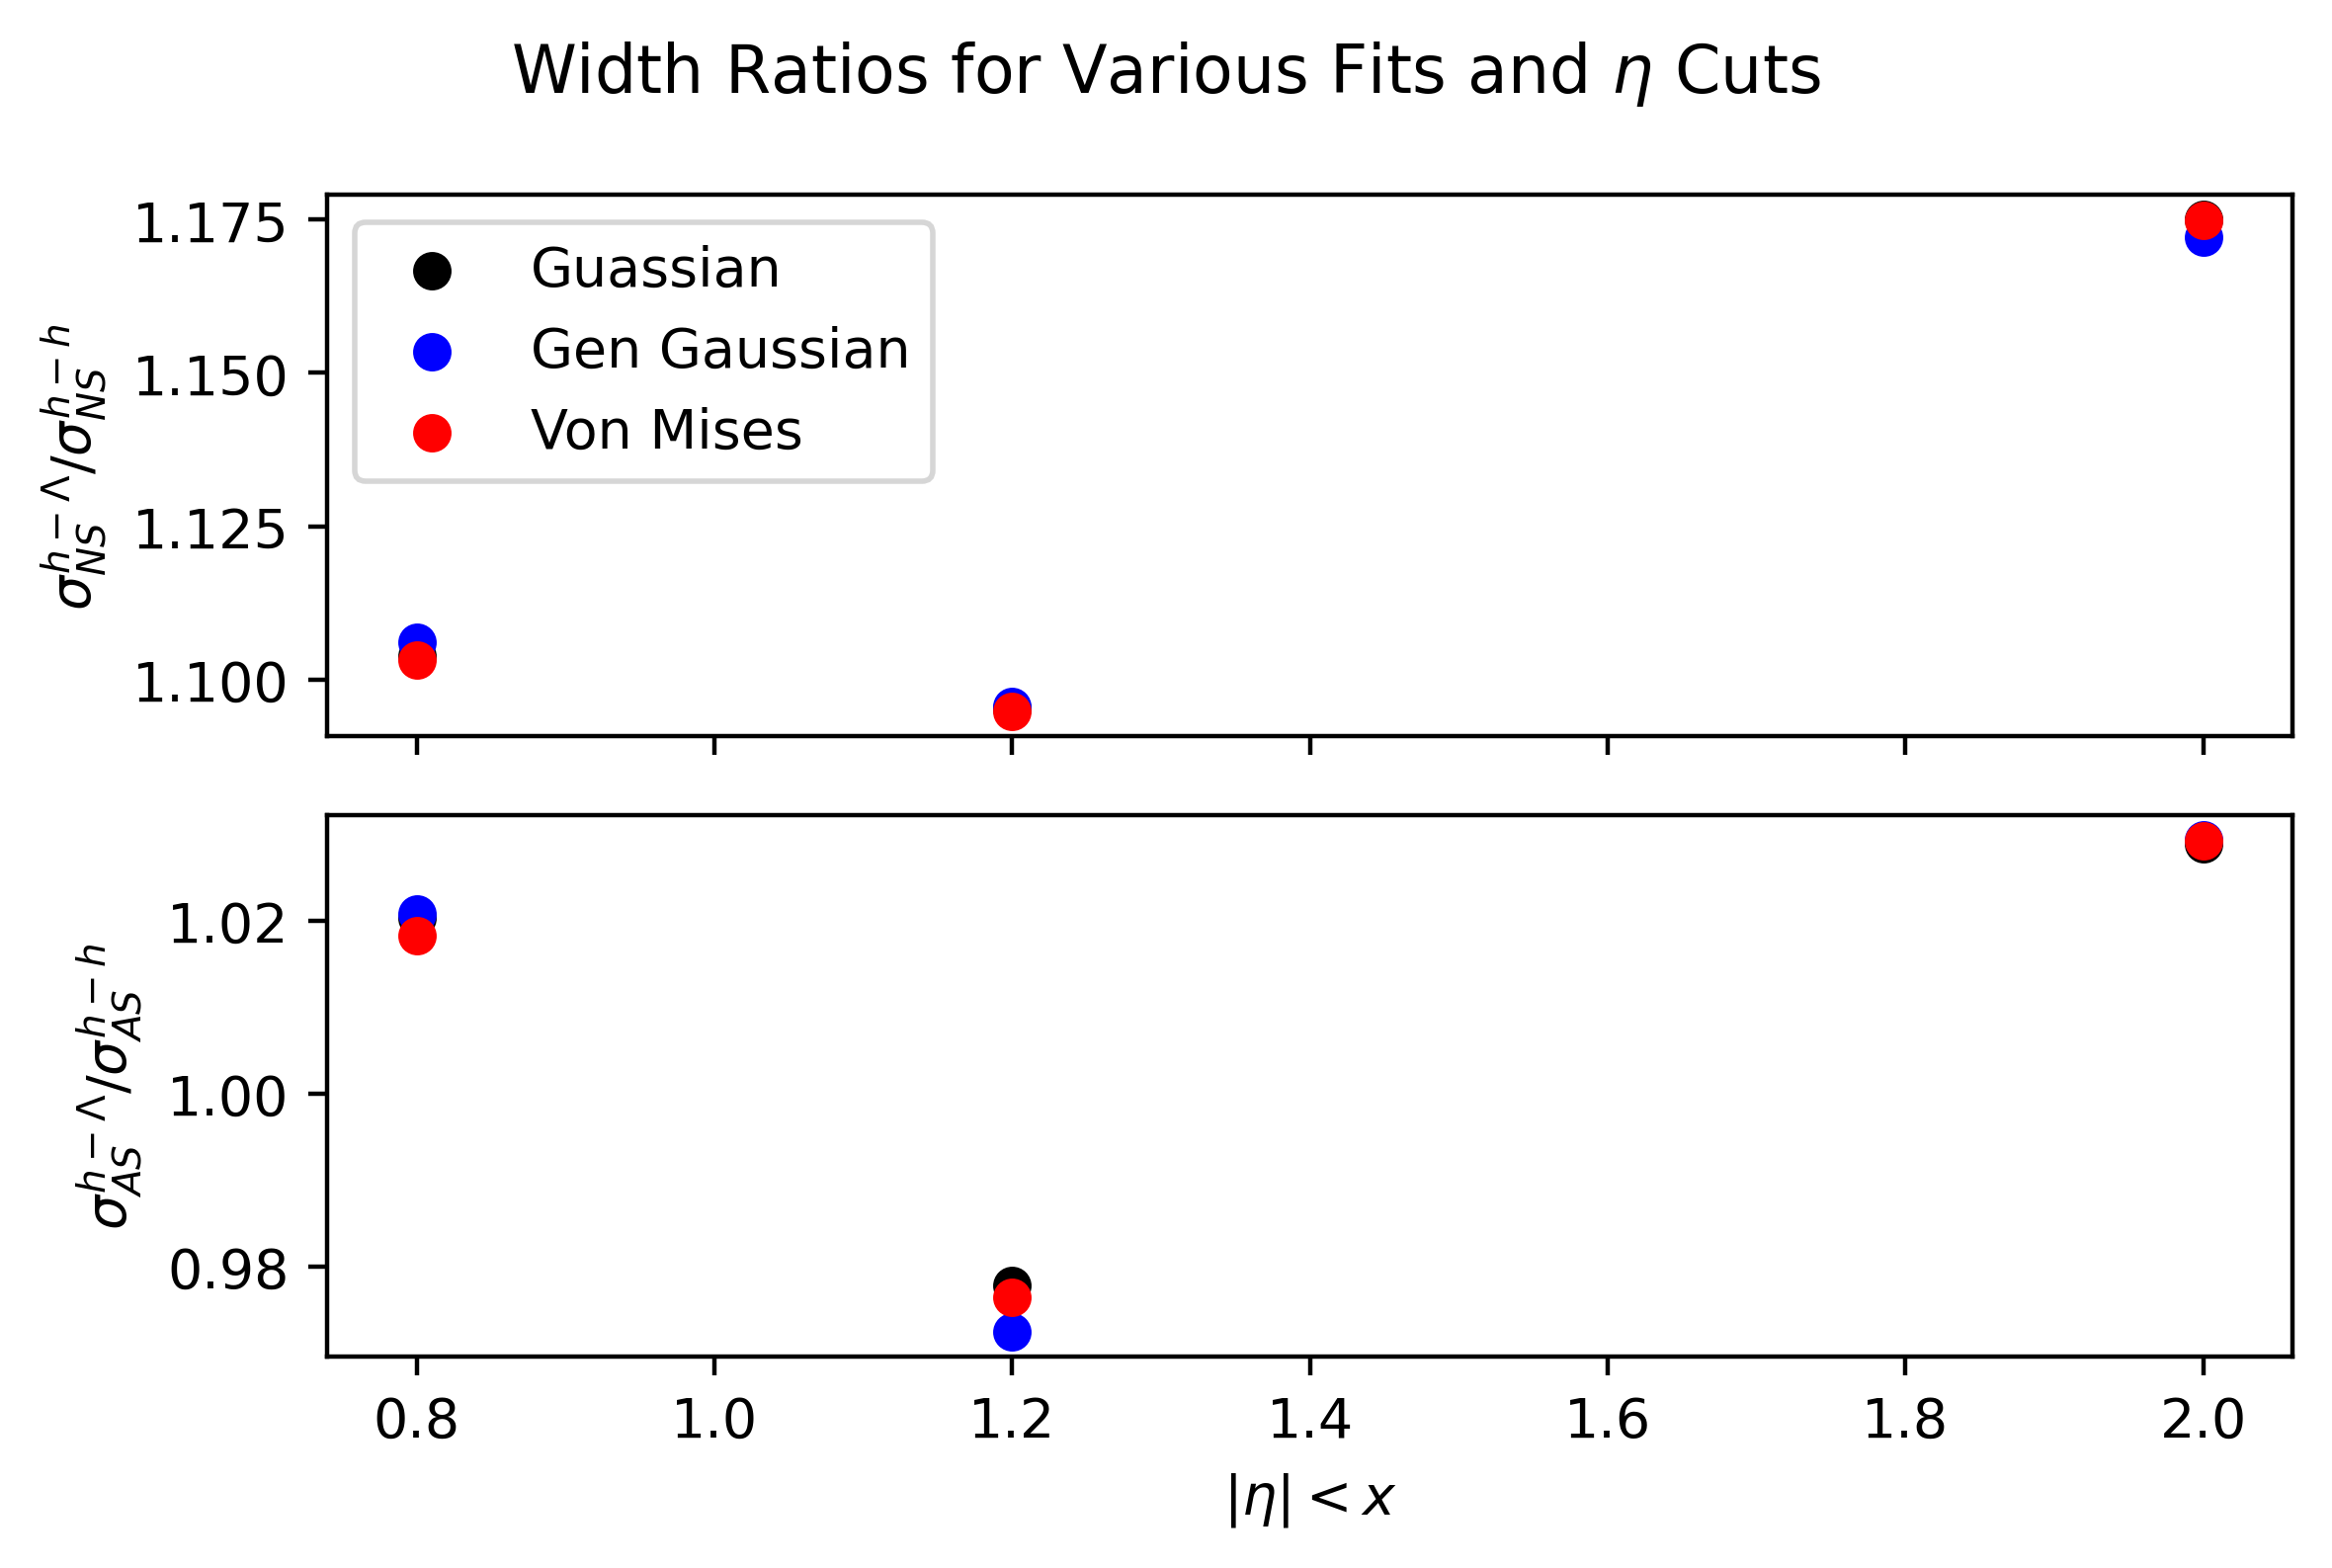

In [45]:
fig, axs = plt.subplots(2, sharex=True)

eta = [0.8, 1.2, 2.0]
ns_stdevs = [gaus_stdev_near, gen_gaus_stdev_near, mises_stdev_near]
as_stdevs = [gaus_stdev_away, gen_gaus_stdev_away, mises_stdev_away]
colors = ['k', 'b', 'r']
labels = ['Guassian', 'Gen Gaussian', 'Von Mises']

for ns_stdev, as_stdev, color, label in zip(ns_stdevs, as_stdevs, colors, labels):
    near_ratios = ns_stdev[3:] / ns_stdev[:3] # h-L / h-h near side
    away_ratios = as_stdev[3:] / as_stdev[:3] # h-L / h-h away side

    axs[0].scatter(eta, near_ratios, color=color, label=label)
    axs[1].scatter(eta, away_ratios, color=color, label=label)

axs[0].legend()
axs[1].set_xlabel('$|\eta|<x$')
axs[0].set_ylabel('$\sigma^{h-\Lambda}_{NS} / \sigma^{h-h}_{NS}$')
axs[1].set_ylabel('$\sigma^{h-\Lambda}_{AS} / \sigma^{h-h}_{AS}$')
fig.suptitle('Width Ratios for Various Fits and $\eta$ Cuts')
plt.tight_layout()

## Away-Side Ratios

In [26]:
def make_away_side_ratio_plots(sparse1, sparse2, eta_assoc_ranges):
    '''
    Calculate and graph away-side ratios for a range of associate eta cuts. 

    Args
        sparse1 (THnSparse): numerator
        sparse2 (THnSparse): denominator 

    Returns
        graph (TGraphErrors)
    '''
    
    yieldRatios = np.zeros(len(eta_assoc_ranges), dtype='d')
    yieldRatioUncerts = np.zeros(len(eta_assoc_ranges), dtype='d')
    etaLabels = np.array([np.abs(etaRange[0]) for etaRange in eta_assoc_ranges], dtype='d')

    for i, eta_assoc in enumerate(eta_assoc_ranges): 
        sparse1Cut = SparseAnalyzer(sparse1, 'numerator_dist', etaAssoc=eta_assoc)
        sparse2Cut = SparseAnalyzer(sparse2, 'denom_dist', etaAssoc=eta_assoc)

        numerator = sparse1Cut.integrate_away_side()
        denominator = sparse2Cut.integrate_away_side()

        yieldRatio = numerator / denominator
        yieldRatios[i] = yieldRatio

        sigma = yieldRatio * np.sqrt(1 / numerator + 1 / denominator)
        yieldRatioUncerts[i] = sigma

    etaLabels.ravel()
    etaLabelsUncerts = np.zeros(len(etaLabels), dtype='d').ravel()
    yieldRatios.ravel()
    yieldRatioUncerts.ravel()

    graph = rt.TGraphErrors(len(etaLabels), etaLabels, yieldRatios, ex=etaLabelsUncerts, ey=yieldRatioUncerts)

    return graph

In [27]:
ratioCanvas = rt.TCanvas()
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)
#ratioCanvas.SetCanvasSize(800, 400)

ratioGraph = make_away_side_ratio_plots(hlDist, hhDist, eta_assoc_ranges=[[-2, 2-eps], [-1.2, 1.2-eps], [-0.8, 0.8-eps]])
ratioGraph.SetMarkerStyle(107)
ratioGraph.SetTitle('Away Side Yield Ratios per #eta Cut')
ratioGraph.GetXaxis().SetTitle('|#eta^{assoc}| < x')
ratioGraph.GetYaxis().SetTitle('Y^{h-#Lambda}_{AS} / Y^{h-h}_{AS}')

process_tgraph(ratioGraph)
ratioGraph.GetYaxis().SetTitleOffset(1.0)

ratioGraph.SetMaximum(22e-3)
ratioGraph.SetMinimum(16e-3)

# ratioGraph.GetYaxis().SetRangeUser(18, 21)

ratioGraph.Draw('ap')

widthRatiosPave.Draw()
ratioCanvas.Draw()

In [28]:
denseRatioCanvas = rt.TCanvas()
denseRatioCanvas.SetCanvasSize(800, 400)

dense_eta = np.array([[-i*10**-1 , i*10**-1 - eps] for i in range(8, 22, 2)])
denseRatioGraph = make_away_side_ratio_plots(hlDist, hhDist, eta_assoc_ranges=dense_eta)

linear = rt.TF1('linear_fit', 'pol1(0)')
denseRatioGraph.Fit('linear_fit')

denseRatioGraph.SetMarkerStyle(107)
denseRatioGraph.SetTitle('#(h - \Lambda)_{away} / (h - h)_{away}; |#eta|; away side ratio')

denseRatioGraph.Draw('ap')
denseRatioCanvas.Draw()


****************************************
Minimizer is Linear / Migrad
Chi2                      =     0.119585
NDf                       =            5
p0                        =    0.0191052   +/-   0.00112562  
p1                        =  0.000331446   +/-   0.000728719 


In [29]:
def make_near_side_ratio_plots(sparse1, sparse2, eta_assoc_ranges):
    '''
    Calculate and graph near-side ratios for a range of associate eta cuts. 

    Args
        sparse1 (THnSparse): numerator
        sparse2 (THnSparse): denominator 

    Returns
        graph (TGraphErrors)
    '''
    
    yieldRatios = np.zeros(len(eta_assoc_ranges), dtype='d')
    yieldRatioUncerts = np.zeros(len(eta_assoc_ranges), dtype='d')
    etaLabels = np.array([np.abs(etaRange[0]) for etaRange in eta_assoc_ranges], dtype='d')

    for i, eta_assoc in enumerate(eta_assoc_ranges): 
        sparse1Cut = SparseAnalyzer(sparse1, 'numerator_dist', etaAssoc=eta_assoc)
        sparse2Cut = SparseAnalyzer(sparse2, 'denom_dist', etaAssoc=eta_assoc)

        numerator = sparse1Cut.integrate_near_side()
        denominator = sparse2Cut.integrate_near_side()

        yieldRatio = numerator / denominator
        yieldRatios[i] = yieldRatio

        sigma = yieldRatio * np.sqrt(1 / numerator + 1 / denominator)
        yieldRatioUncerts[i] = sigma

    etaLabels.ravel()
    etaLabelsUncerts = np.zeros(len(etaLabels), dtype='d').ravel()
    yieldRatios.ravel()
    yieldRatioUncerts.ravel()

    graph = rt.TGraphErrors(len(etaLabels), etaLabels, yieldRatios, ex=etaLabelsUncerts, ey=yieldRatioUncerts)

    return graph

In [30]:
nsYieldRatioCanvas = rt.TCanvas()
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)

nsYieldRatioGraph = make_near_side_ratio_plots(hlDist, hhDist, eta_assoc_ranges=[[-2, 2-eps], [-1.2, 1.2-eps], [-0.8, 0.8-eps]])
nsYieldRatioGraph.SetMarkerStyle(21)
nsYieldRatioGraph.SetMarkerColor(4)
nsYieldRatioGraph.SetLineColor(4)

nsYieldRatioGraph.SetTitle('Near Side Yield Ratios per #eta Cut')
nsYieldRatioGraph.GetXaxis().SetTitle('|#eta^{assoc}| < x')
nsYieldRatioGraph.GetYaxis().SetTitle('Y^{h-#Lambda}_{NS} / Y^{h-h}_{NS}')

nsYieldRatioGraph.SetMinimum(3e-3)
nsYieldRatioGraph.SetMaximum(6e-3)

process_tgraph(nsYieldRatioGraph)

#nsYieldRatioGraph.GetYaxis().SetRangeUser(4, 6)

nsYieldRatioGraph.Draw('ap')
widthRatiosPave.Draw()
nsYieldRatioCanvas.Draw()

In [31]:
nsDenseRatioCanvas = rt.TCanvas()
nsDenseRatioCanvas.SetCanvasSize(800, 400)

dense_eta = np.array([[-i*10**-1 , i*10**-1 - eps] for i in range(8, 22, 2)])
nsDenseRatioGraph = make_near_side_ratio_plots(hlDist, hhDist, eta_assoc_ranges=dense_eta)

linear = rt.TF1('linear_fit_ns', 'pol1(0)')
nsDenseRatioGraph.Fit('linear_fit_ns')

nsDenseRatioGraph.SetMarkerStyle(107)
nsDenseRatioGraph.SetTitle('#(h - \Lambda)_{away} / (h - h)_{away}; |#eta|; near side ratio')

nsDenseRatioGraph.Draw('ap')
nsDenseRatioCanvas.Draw()


****************************************
Minimizer is Linear / Migrad
Chi2                      =    0.0326882
NDf                       =            5
p0                        =   0.00436039   +/-   0.000471743 
p1                        =  0.000106762   +/-   0.000323187 


In [32]:
def make_away_over_near_plots(sparse, eta_assoc_ranges):
    
    yieldRatios = np.zeros(len(eta_assoc_ranges), dtype='d')
    yieldRatioUncerts = np.zeros(len(eta_assoc_ranges), dtype='d')
    etaLabels = np.array([np.abs(etaRange[0]) for etaRange in eta_assoc_ranges], dtype='d')

    for i, eta_assoc in enumerate(eta_assoc_ranges): 
        sparseCut = SparseAnalyzer(sparse, 'cut_sparse', etaAssoc=eta_assoc)

        numerator = sparseCut.integrate_away_side()
        denominator = sparseCut.integrate_near_side()

        yieldRatio = numerator / denominator
        yieldRatios[i] = yieldRatio

        sigma = yieldRatio * np.sqrt(1 / numerator + 1 / denominator)
        yieldRatioUncerts[i] = sigma

    etaLabels.ravel()
    etaLabelsUncerts = np.zeros(len(etaLabels), dtype='d').ravel()
    yieldRatios.ravel()
    yieldRatioUncerts.ravel()

    graph = rt.TGraphErrors(len(etaLabels), etaLabels, yieldRatios, ex=etaLabelsUncerts, ey=yieldRatioUncerts)

    return graph
    

In [33]:
hhRatios = make_away_over_near_plots(hhDist, eta_assoc_ranges=[[-2, 2-eps], [-1.2, 1.2-eps], [-0.8, 0.8-eps]])
hhRatios.SetMarkerStyle(22)
hhRatios.SetTitle('h-h yield ratio per #eta cut')

hlRatios = make_away_over_near_plots(hlDist, eta_assoc_ranges=[[-2, 2-eps], [-1.2, 1.2-eps], [-0.8, 0.8-eps]])
hlRatios.SetMarkerStyle(22)
hlRatios.SetMarkerColor(4)
hlRatios.SetTitle('h-#Lambda yield ratio per #eta cut')

In [34]:
sameRatioCanvas = rt.TCanvas()
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)


sameRatioMG = rt.TMultiGraph('yieldmg', 'away-side yield ratios per #eta cut')

sameRatioMG.Add(hhRatios, 'p')
sameRatioMG.Add(hlRatios, 'p')

sameRatioMG.GetXaxis().SetTitle('|#eta^{assoc}| < x')
sameRatioMG.GetYaxis().SetTitle('Y^{AS} / Y^{NS}')

sameRatioMG.Draw()

sameRatioLegend = sameRatioCanvas.BuildLegend(0.232758, 0.705508, 0.53304, 0.91525)
sameRatioLegend.SetBorderSize(0)
sameRatioLegend.SetFillStyle(0)

sameRatioCanvas.Draw()

## $\Delta \eta$ Distributions

# Correlation Distributions

Question: isn't cutting on THnSparse approximate?

In [31]:
# define to make projections of THnSparse more readable
#   the ints correspond to a particular axis of the correlation THnSparse
axis = {'trigger eta': 0, 'associate eta': 1, 'trigger pT': 2, 'associate pT': 3, 'delta phi': 4, 'delta eta': 5}

# HYPERPARAM
eps = 0.0001
etaTrig = [-0.8, 0.8-eps]

eta = [
    [-2, 2-eps], 
    [-1.2, 1.2-eps], 
    [-0.8, 0.8-eps]]

ptTrig = [4, 8-eps]
ptAssoc = [2, 4-eps]

## Plots with No Cuts

In [ ]:
def make_projection_plots(sparse, ptTrig, ptAssoc):
    '''
    Makes 1D histograms of quantities from THnSparse, and 2D delta phi delta eta correlation. 
    No single particle cuts applied in this function. 

    Args
        sparse (THnSparse):
    
    Returns
        canvas (TCanvas): 
    '''
    ptTrigMin, ptTrigMax = ptTrig
    ptAssocMin, ptAssocMax = ptAssoc

    # select pT cuts for trigger and associate
    sparse.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
    sparse.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)

    # project to make 1D hists
    trigEta = sparse.Projection(axis['trigger eta'])
    assocEta = sparse.Projection(axis['associate eta'])
    trigPt = sparse.Projection(axis['trigger pT'])
    assocPt = sparse.Projection(axis['associate pT'])
    dEta = sparse.Projection(axis['delta eta']) 

    # project into 2D correlations and delta eta dist
    dPhiDEta = sparse.Projection(axis['delta eta'], axis['delta phi'])
    #dEta = dPhiDEta.ProjectionY()

    # reset sparse pT axes
    sparse.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)
    sparse.GetAxis(axis['associate pT']).SetRangeUser(0, 0)

    # make canvas
    gStyle.SetOptStat(11)
    canvas = TCanvas('canvas', 'title')
    canvas.SetCanvasSize(1800, 800)
    canvas.Divide(3, 2)

    canvas.cd(1)
    format_hist(trigEta)
    trigEta.GetYaxis().SetRangeUser(0, 1.3*trigEta.GetMaximum())
    trigEta.SetTitle('Trigger #eta')
    trigEta.SetXTitle('#eta')
    trigEta.SetYTitle('counts')
    trigEta.Draw('COLZ')


    canvas.cd(2)
    format_hist(assocEta)
    assocEta.SetTitle('Associate #eta')
    assocEta.SetXTitle('#eta')
    assocEta.SetYTitle('counts')
    assocEta.Draw('COLZ')


    canvas.cd(3)
    format_hist(trigPt)
    trigPt.SetTitle('Trigger p_{T}')
    trigPt.SetXTitle('p_{T}')
    trigPt.SetYTitle('counts')
    trigPt.Draw('COLZ')


    canvas.cd(4)
    format_hist(assocPt)
    assocPt.SetTitle('Associate p_{T}')
    assocPt.SetXTitle('p_{T}')
    assocPt.SetYTitle('counts')
    assocPt.Draw('COLZ')


    canvas.cd(5)
    format_hist(dPhiDEta)
    dPhiDEta.SetTitle('Correlation')
    dPhiDEta.SetXTitle('#Delta#varphi')
    dPhiDEta.SetYTitle('#Delta#eta')
    dPhiDEta.GetYaxis().SetRangeUser(-1.2, 1.199)
    dPhiDEta.Draw('SURF1')


    canvas.cd(6)
    format_hist(dEta)
    dEta.SetTitle('#Delta#eta')
    dEta.SetXTitle('#Delta#eta')
    dEta.SetYTitle('counts')
    dEta.Draw()    

    return canvas

In [ ]:
c1 = make_projection_plots(hhDist, ptTrig, ptAssoc)
c1.Draw()

NameError: name 'gStyle' is not defined

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


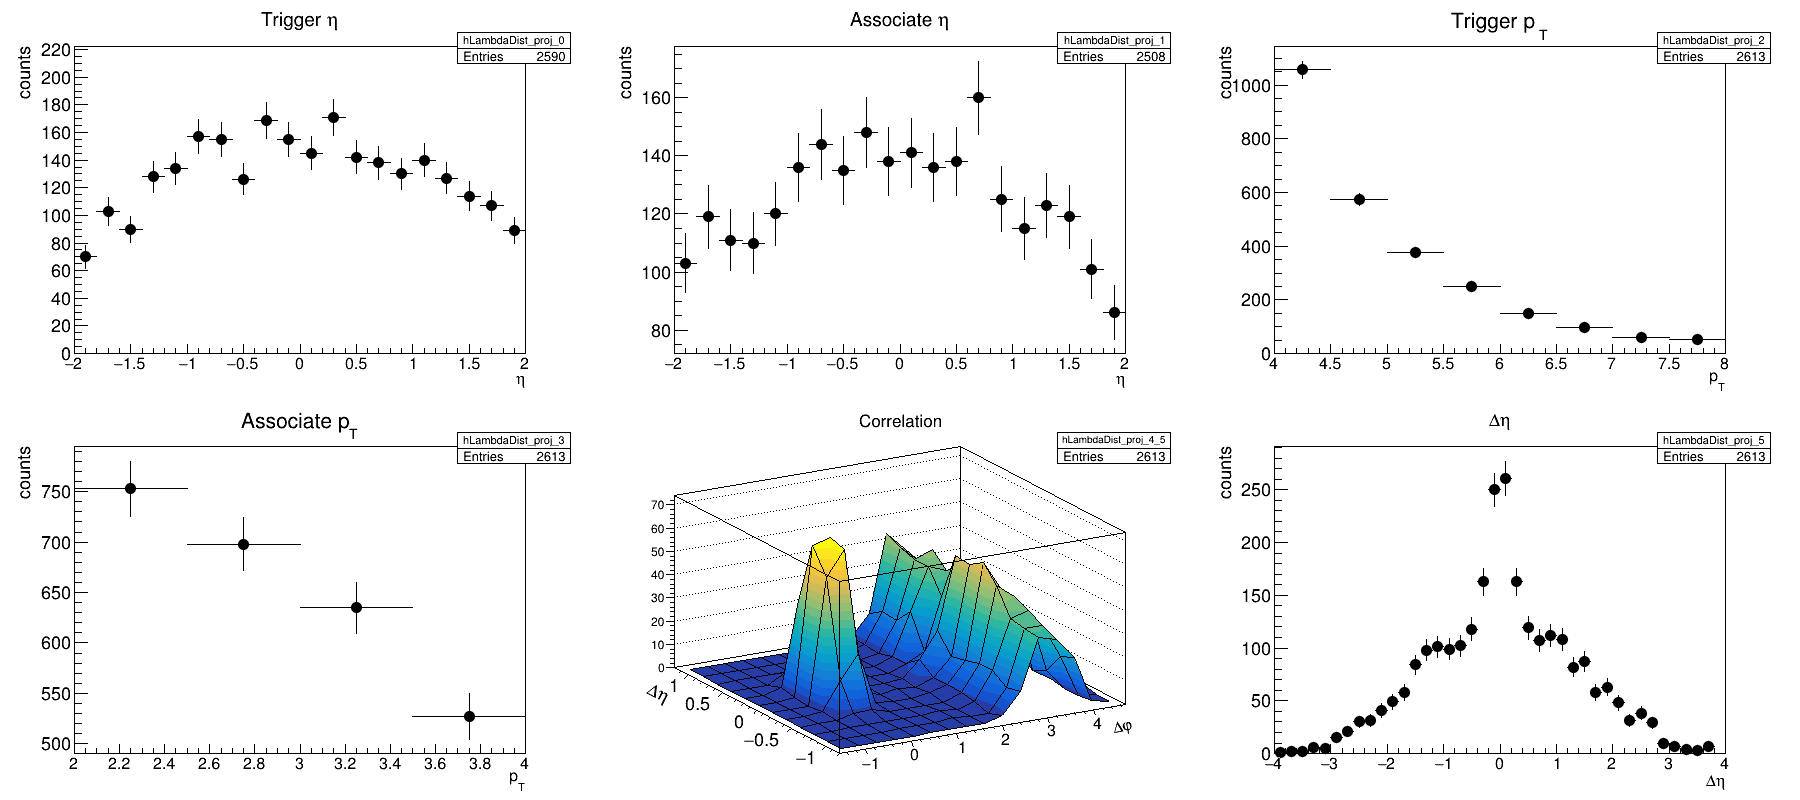

In [ ]:
c2 = make_projection_plots(hlDist, ptTrig, ptAssoc)
c2.Draw()

## Away Side Ratios

In [ ]:
# Skeleton of the following analysis: 
# for both hh and hL
# select pT range for trigger and associate
# for each eta cut
#   plot delta phi delta eta
#   integrate away side peak counts
#   reset eta cut

In [ ]:
def integrate_away_side(correlation):
    '''
    Helper function for get_away_side_ratios(). Calculates the counts in the away side peak of a 2D delta phi delta eta correlation.

    Args
        correlation (TH2):

    Returns
        away_yield (float): 
    '''

    # bounds of integral
    pi = TMath.Pi()
    eps = 0.0001 # in case upper bound lands on right bin edge
    dPhi_lower = pi / 2
    dPhi_upper = 3 * pi / 2 - eps
    dEta_lower = -50
    dEta_upper = 50 - eps

    dPhiLowerBin = correlation.GetXaxis().FindBin(dPhi_lower)
    dPhiUpperBin = correlation.GetXaxis().FindBin(dPhi_upper)

    dEtaLowerBin = correlation.GetYaxis().FindBin(dEta_lower)
    dEtaUpperBin = correlation.GetYaxis().FindBin(dEta_upper)

    away_yield = correlation.Integral(dPhiLowerBin, dPhiUpperBin, dEtaLowerBin, dEtaUpperBin)

    return away_yield

In [ ]:
def get_away_side_ratios(sparse1, sparse2, ptTrig, ptAssoc, etaTrig, etaAssoc):
    '''
    Given a particular single particle pT and eta cut, 
    returns the ratio of counts in the away side peak for a del phi del eta distribution. 

    Args
        sparse1 (THnSparse): numerator
        sparse2 (THnSparse): denomen
        ptTrig (array-like):
        ptAssoc (array-like):
        etaRanges (array-like):

    Returns
        ratios (tuple): h-Lambda / h-h for given single particle and eta cut
    '''

    # apply pT cut
    ptTrigMin, ptTrigMax = ptTrig
    ptAssocMin, ptAssocMax = ptAssoc
    etaTrigMin, etaTrigMax = etaTrig

    sparse1.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
    sparse2.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)

    sparse1.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)
    sparse2.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)

    sparse1.GetAxis(axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)
    sparse2.GetAxis(axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)
    
    yieldRatios = []
    yieldRatiosUncerts = []
    # iterate over eta cuts
    for etaRange in etaAssoc:
        etaAssocMin, etaAssocMax = etaRange

        # apply eta cuts
        sparse1.GetAxis(axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)
        sparse2.GetAxis(axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)

        # project into 2D correlations
        dPhiDEta1 = sparse1.Projection(axis['delta eta'], axis['delta phi'])
        dPhiDEta2 = sparse2.Projection(axis['delta eta'], axis['delta phi']) 

        # integrate the counts in the away side peak
        awayCts1 = integrate_away_side(dPhiDEta1)
        awayCts2 = integrate_away_side(dPhiDEta2)

        awayYieldRatio = awayCts1 / awayCts2
        yieldRatios.append(awayYieldRatio)

        # naive calc: standard formula for uncertainty w/ division, assuming we treat the away side as one large bin
        assert awayYieldRatio > 0, 'ratio should be positive'
        sigma = awayYieldRatio * np.sqrt( 1 / awayCts1 + 1 / awayCts2)
        yieldRatiosUncerts.append(sigma)


    # reset dist axes
    sparse1.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)

    sparse1.GetAxis(axis['associate pT']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['associate pT']).SetRangeUser(0, 0)

    sparse1.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)

    sparse1.GetAxis(axis['associate eta']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['associate eta']).SetRangeUser(0, 0)

    return yieldRatios, yieldRatiosUncerts

In [ ]:
hlOverhh, hlOverhhSigma = get_away_side_ratios(hlDist, hhDist, ptTrig=[4, 8], ptAssoc=[2, 4], etaTrig=etaTrig, etaAssoc=eta)

Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).


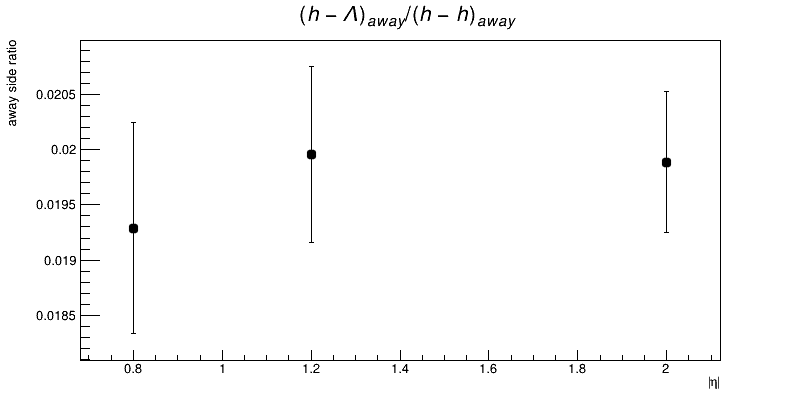

In [ ]:
x = []
for etaRange in eta:
    x.append(np.abs(etaRange[0]))

# flatten data for TGraph
x = np.array(x, dtype='d').ravel()#.flatten('C')
y = np.array(hlOverhh, dtype='d').ravel()#.flatten('C')
sigmax = np.zeros(len(x))
sigmay = np.array(hlOverhhSigma, dtype='d').ravel()

#g = TGraph(len(x), x, y)
assert (len(x) == len(y)) and (len(x) == len(sigmay))
g = TGraphErrors(len(x), x, y, ex=sigmax, ey=sigmay)
g.SetMarkerStyle(107)
g.SetTitle('#(h - \Lambda)_{away} / (h - h)_{away}; |#eta|; away side ratio')


gCanvas = TCanvas()
gCanvas.SetCanvasSize(800, 400)
g.Draw("ap") # draw as scatter points and the axis
gCanvas.Draw()

 FCN=0.119585 FROM MIGRAD    STATUS=CONVERGED      42 CALLS          43 TOTAL
                     EDM=1.07882e-20    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.91052e-02   1.12562e-03   1.43449e-07   6.53022e-09
   2  p1           3.31446e-04   7.28719e-04   1.03428e-07   2.11332e-07


Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existin

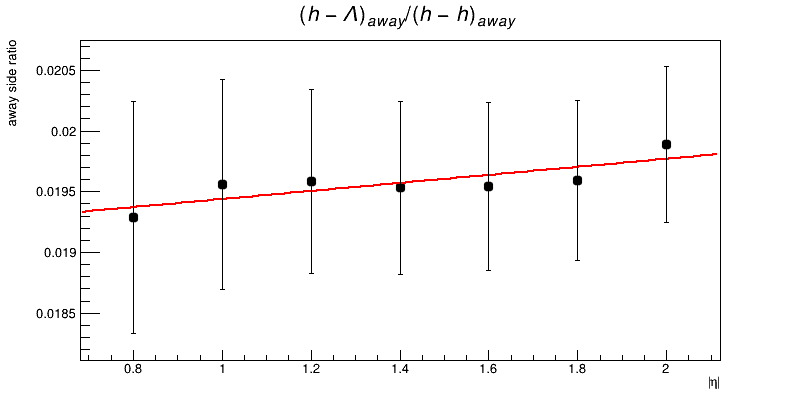

In [ ]:
dense_eta = [[-i*10**-1 , i*10**-1 - eps] for i in range(8, 22, 2)]

x = []
for etaRange in dense_eta:
    x.append(np.abs(etaRange[0]))

y, sigmay = get_away_side_ratios(hlDist, hhDist, ptTrig=[4, 8], ptAssoc=[2, 4], etaTrig=etaTrig, etaAssoc=dense_eta)

x = np.array(x, dtype='d').ravel()
y = np.array(y, dtype='d').ravel()
sigmax = np.zeros(len(x)).ravel()
sigmay = np.array(sigmay, dtype='d')

dg = TGraphErrors(len(x), x, y, ex=sigmax, ey=sigmay)
f = TF1('f', '[0] + [1]*x')
dg.Fit(f)

dg.SetMarkerStyle(107)
dg.SetTitle('#(h - \Lambda)_{away} / (h - h)_{away}; |#eta|; away side ratio')


dgCanvas = TCanvas()
dgCanvas.SetCanvasSize(800, 400)
dg.Draw("ap") # draw as scatter points and the axis
dgCanvas.Draw()

## Plots w/ Cuts

In [ ]:
def gen_plots_w_eta_cuts(sparse, name, ptTrig, ptAssoc, etaTrig, etaAssoc):
    '''
    Args
        sparse (THnSparse):
        ptTrig (array-like):
        ptAssoc (array-like):
        etaRanges (array-like):
    '''

    etaTrigMin, etaTrigMax = etaTrig
    sparse.GetAxis(axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)

    canvases = []
    # iterate over eta cuts
    for i, etaRange in enumerate(etaAssoc):
        etaAssocMin, etaAssocMax = etaRange

        # apply eta cuts
        sparse.GetAxis(axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)

        # produce canvas w/ plots
        canvas = make_projection_plots(sparse, ptTrig, ptAssoc)
        canvas.SetName(f'{name}Canvas{np.abs(etaAssocMin)}')
        canvases.append(canvas)    
        
    # reset dist axes
    sparse.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
    sparse.GetAxis(axis['associate eta']).SetRangeUser(0, 0)

    return canvases

In [ ]:
hhCanvas2, hhCanvas12, hhCanvas08 = gen_plots_w_eta_cuts(hhDist, 'hh', ptTrig, ptAssoc, etaTrig=etaTrig, etaAssoc=eta)

Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_3 (Potential memory leak).
Warning in <TF

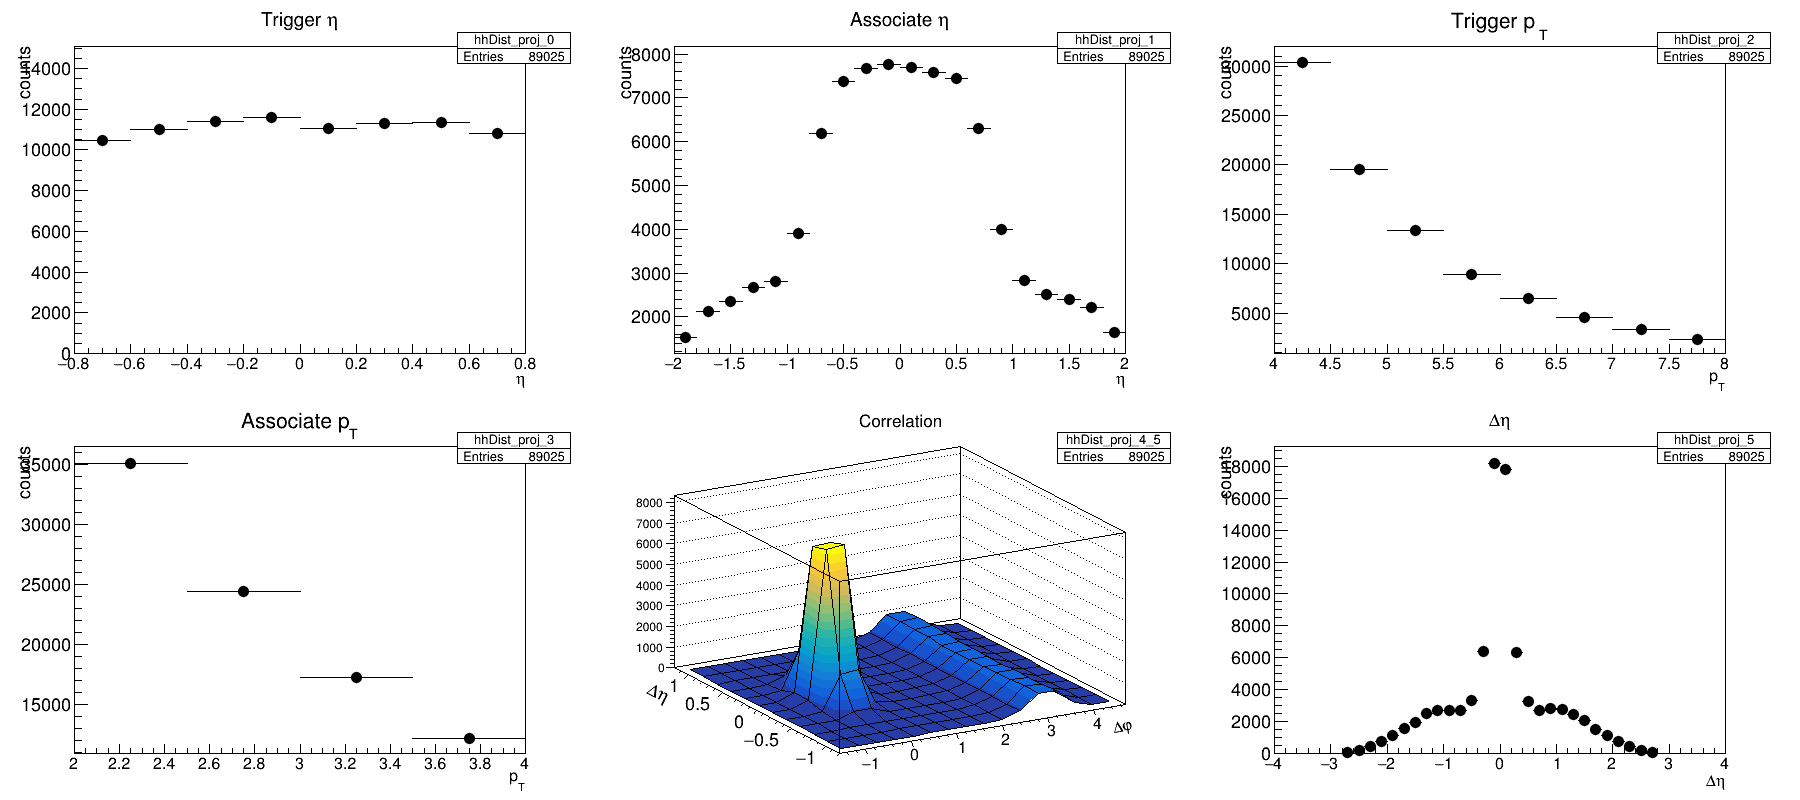

In [ ]:
hhCanvas2.Draw()

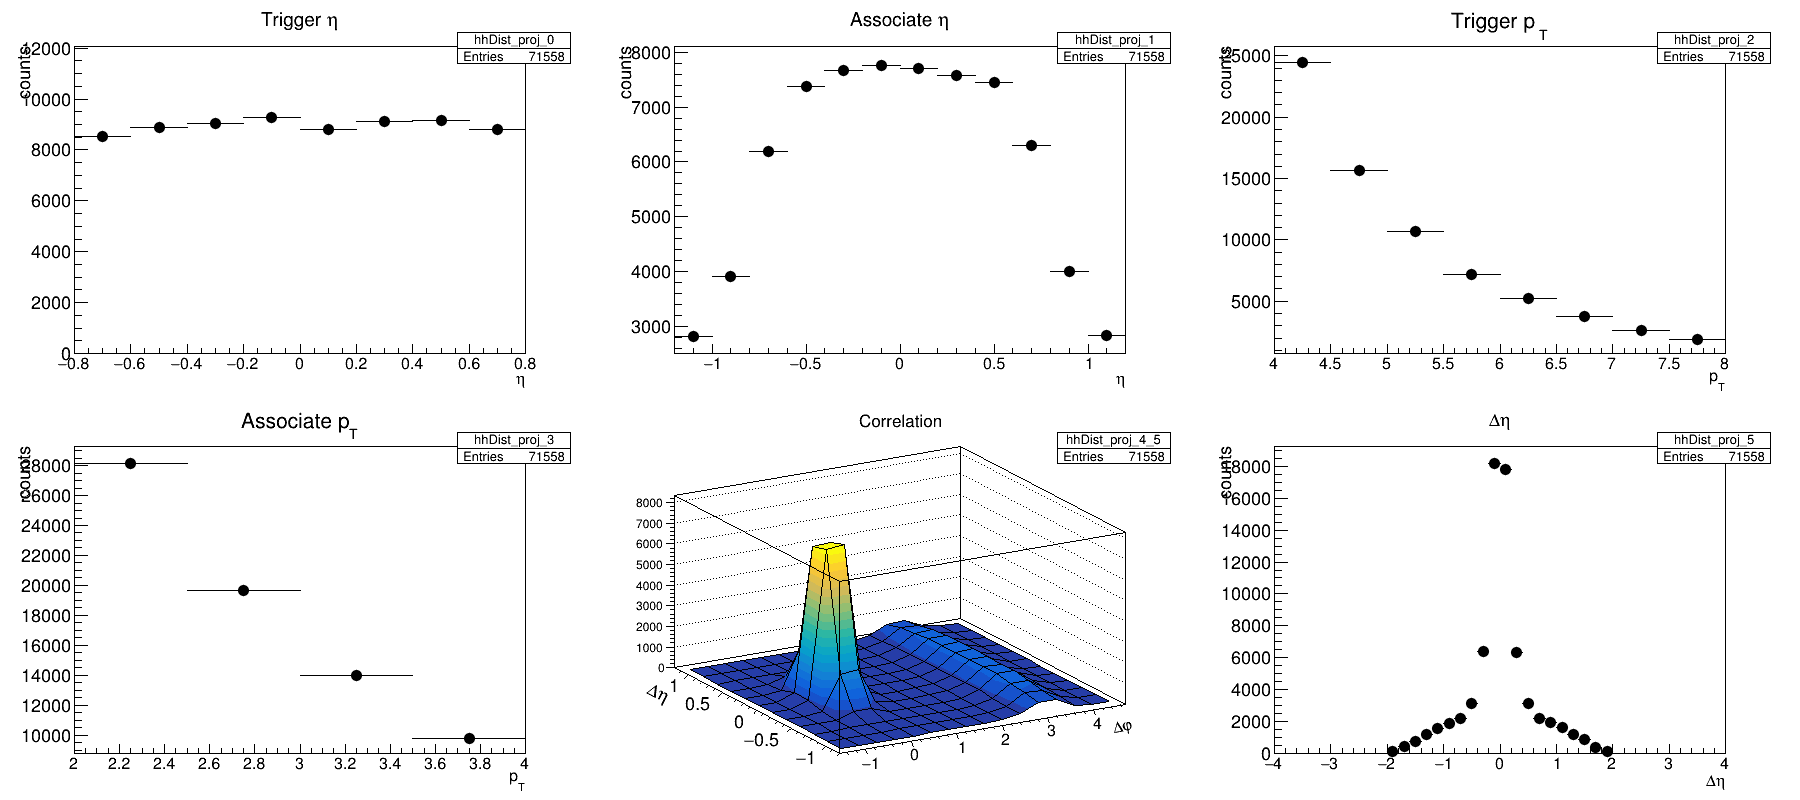

In [ ]:
hhCanvas12.Draw()

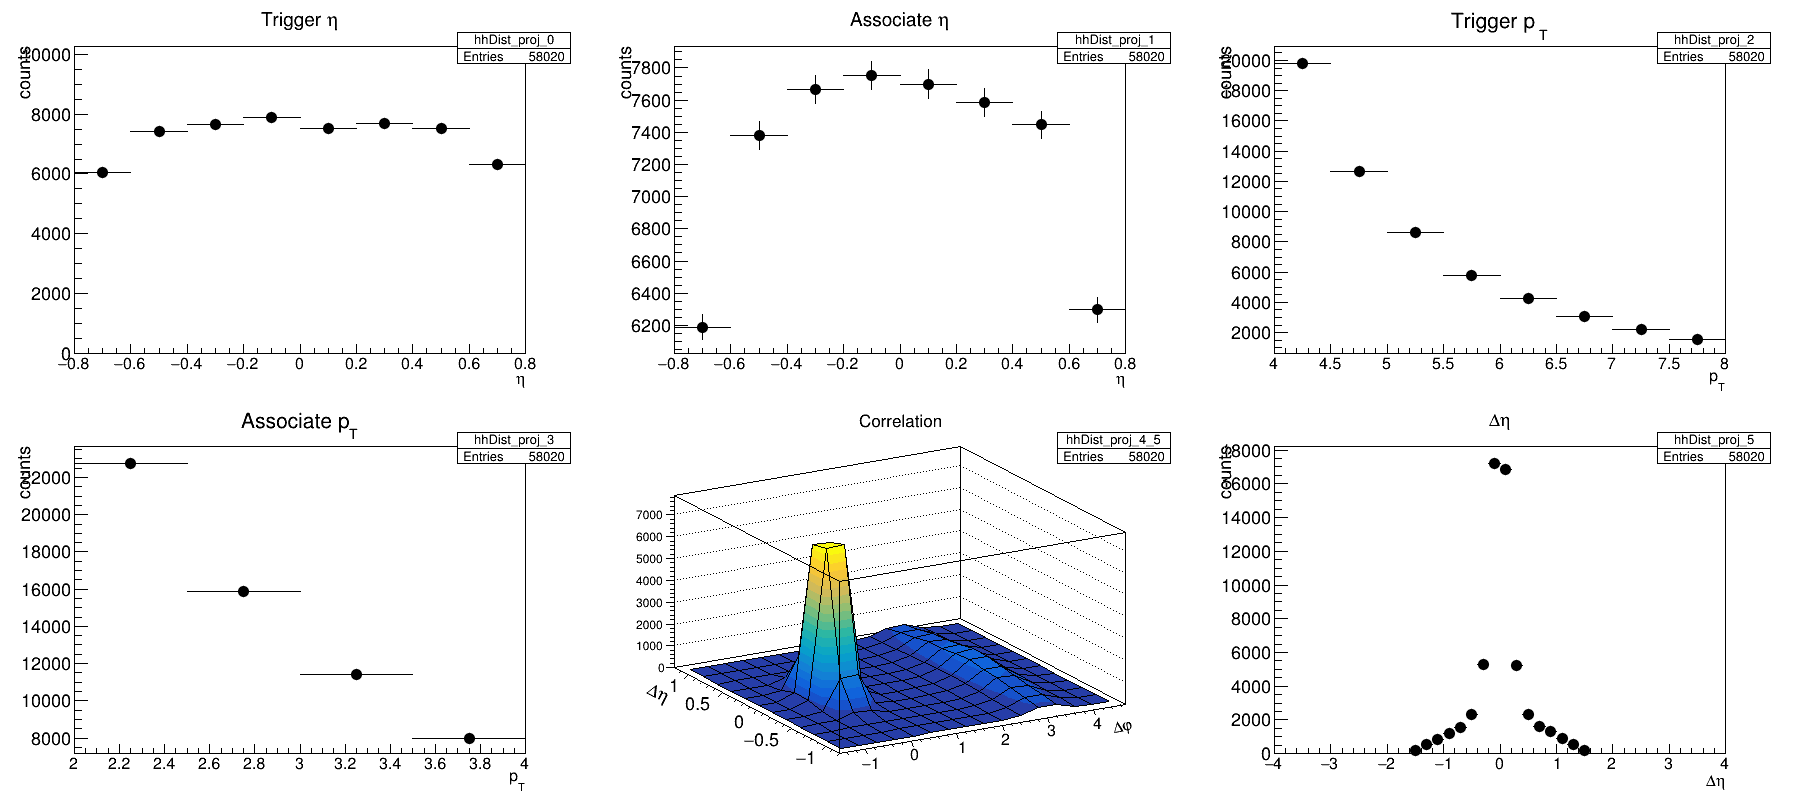

In [ ]:
hhCanvas08.Draw()

In [ ]:
hlCanvas2, hlCanvas12, hlCanvas08 = gen_plots_w_eta_cuts(hlDist, 'hl', ptTrig, ptAssoc, etaTrig=etaTrig, etaAssoc=eta)

Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_3 (Potential memory leak).
Warning in <TFile::Append>: Replacing 

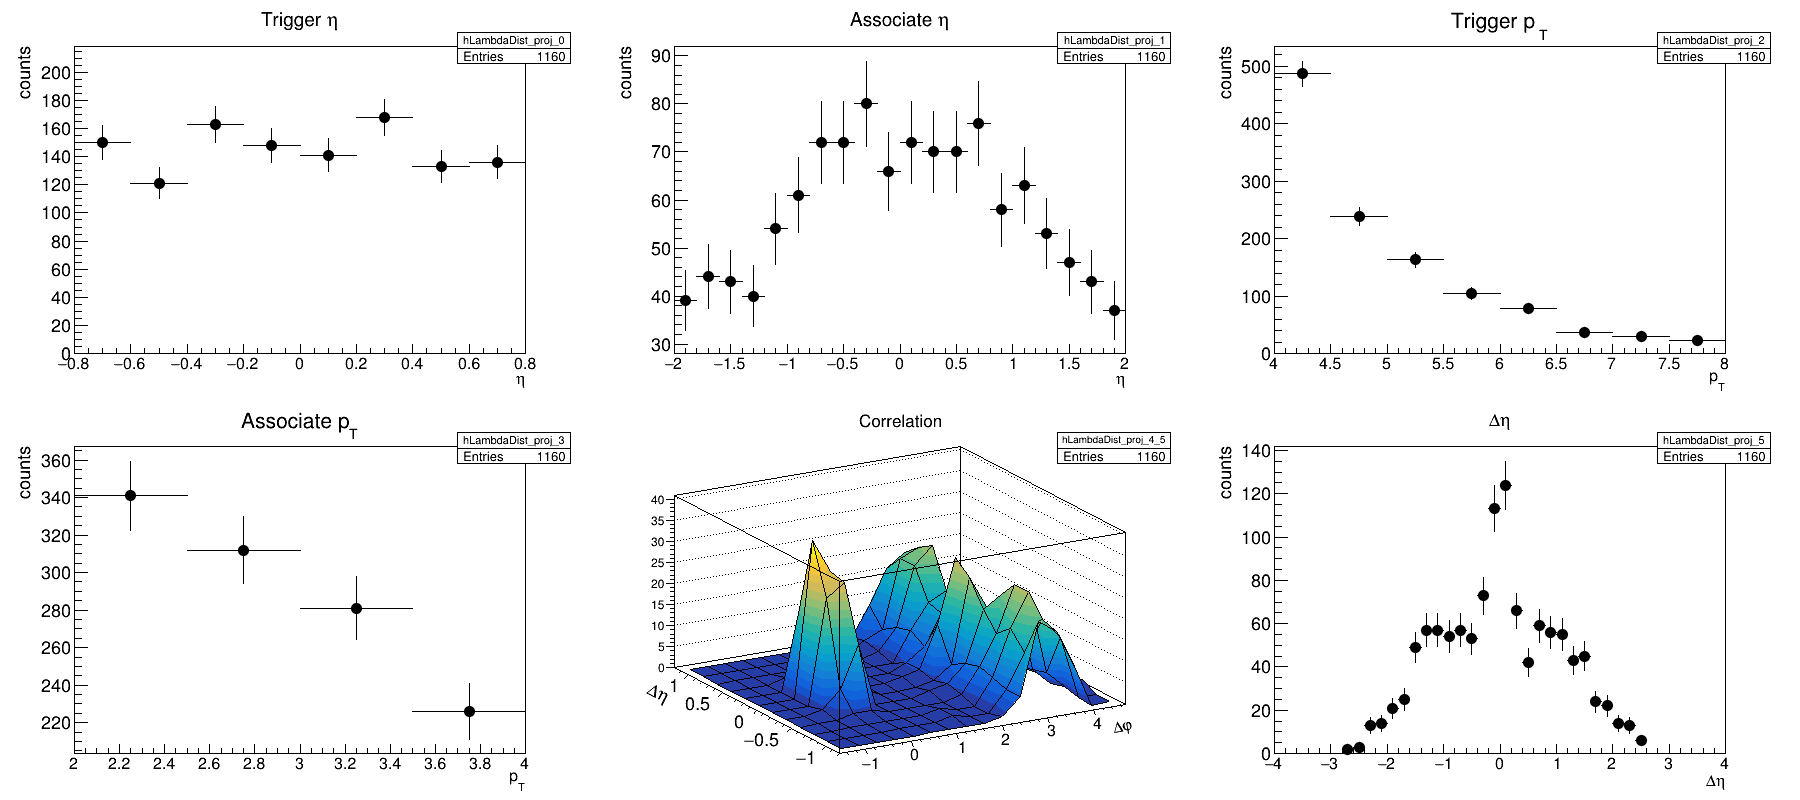

In [ ]:
hlCanvas2.Draw()

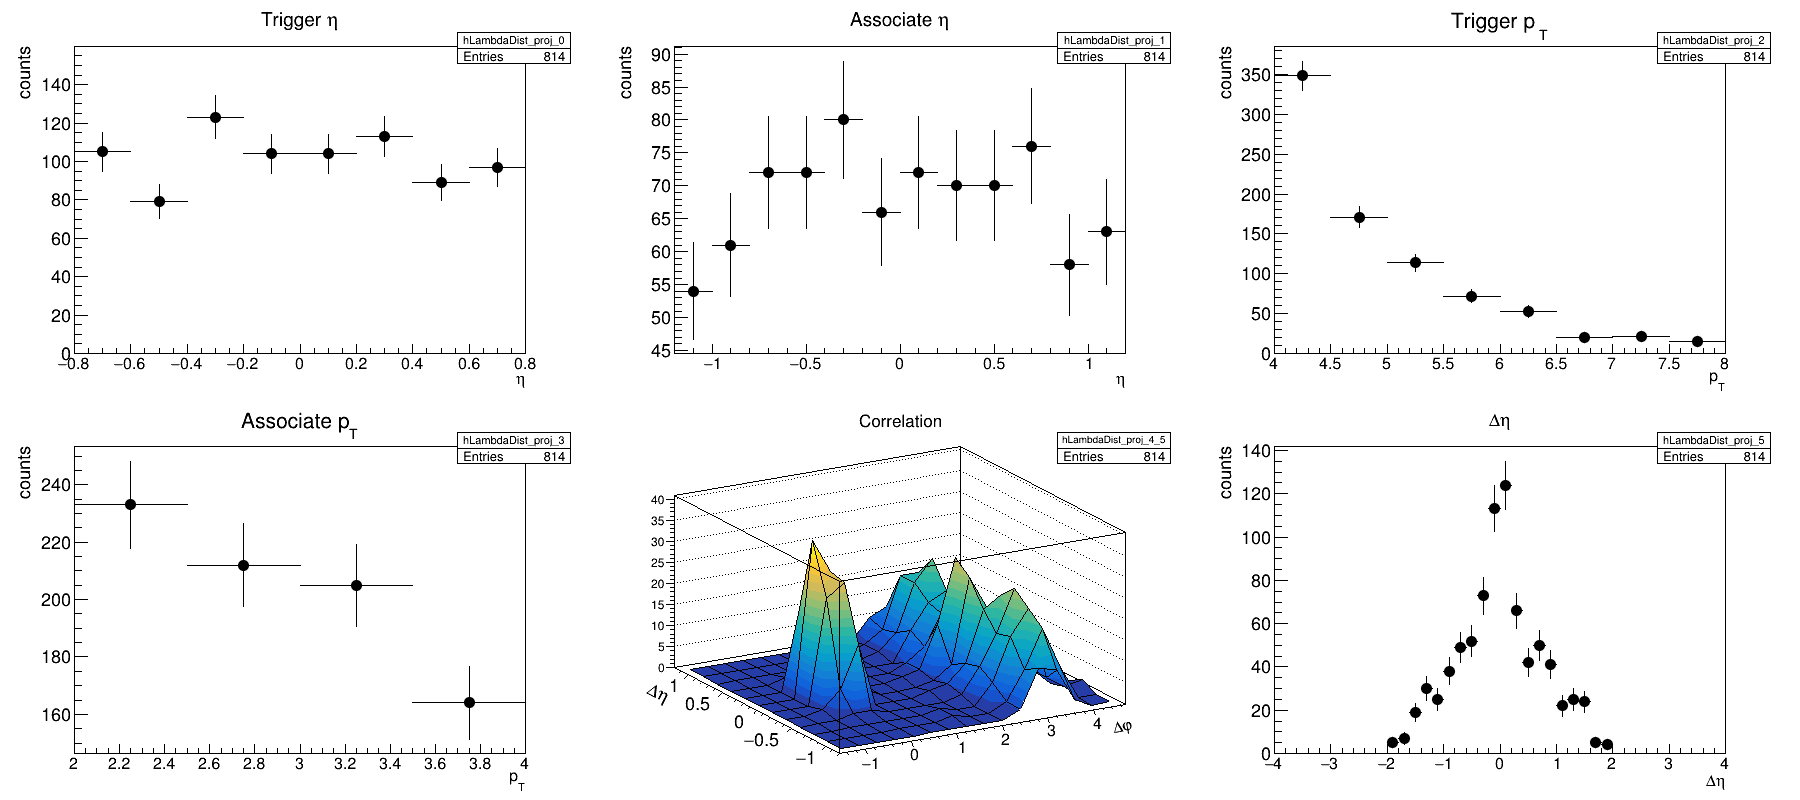

In [ ]:
hlCanvas12.Draw()

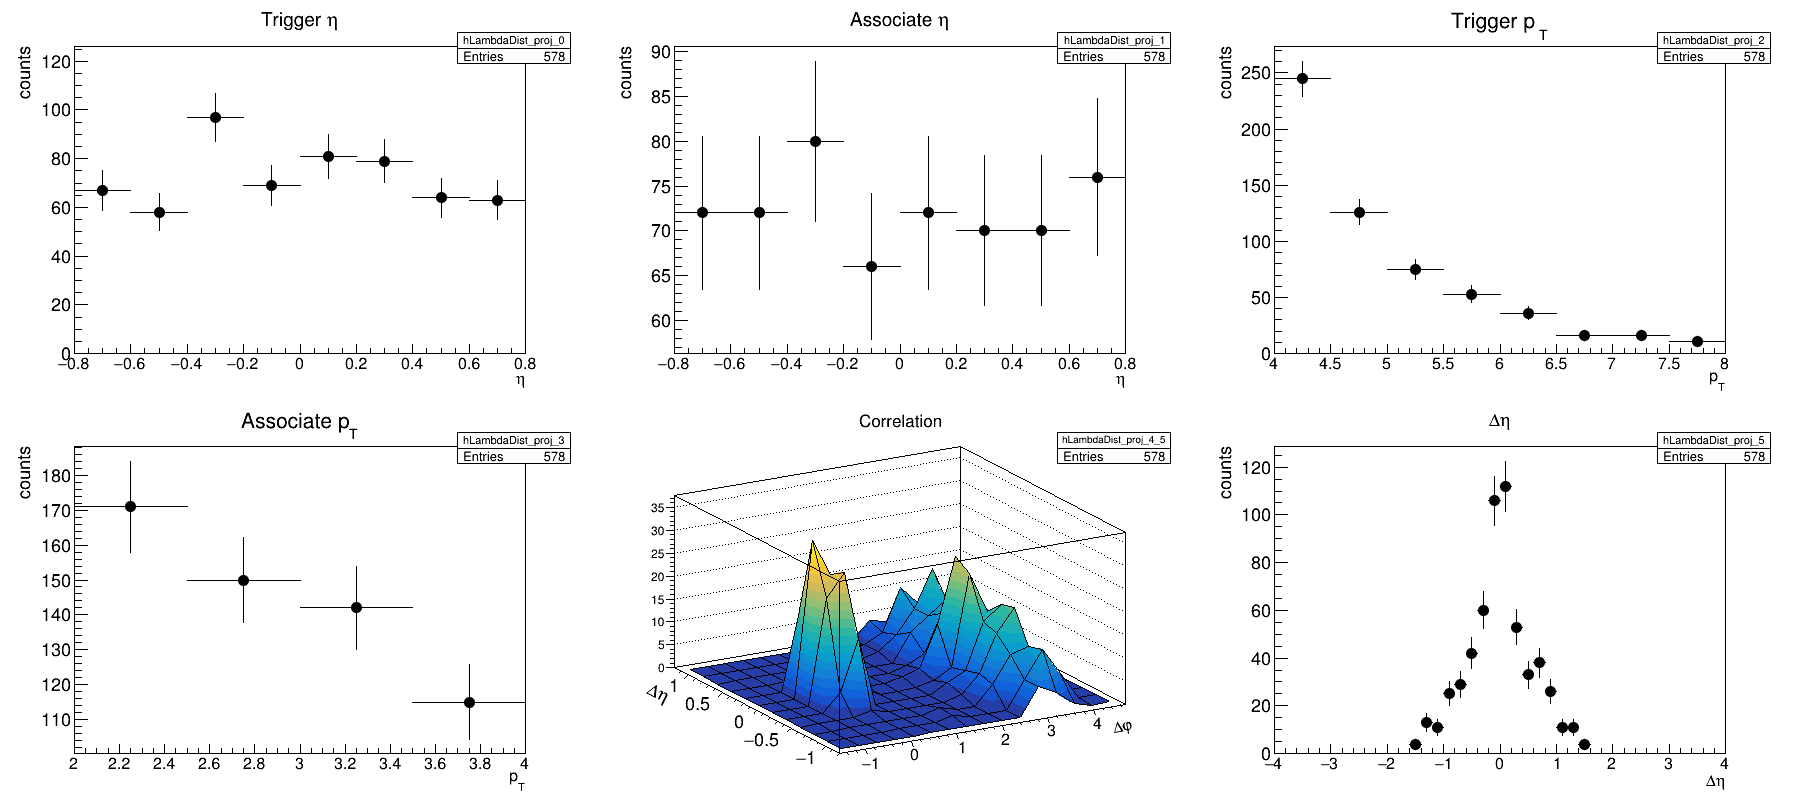

In [ ]:
hlCanvas08.Draw()

## $\Delta \eta$ Distributions for Each Cut

In [ ]:
def make_delta_eta_plots(sparse1, sparse2, ptTrig, ptAssoc, etaTrig, etaAssoc):
# why no pT cuts??????
    ptTrigMin, ptTrigMax = ptTrig
    ptAssocMin, ptAssocMax = ptAssoc

    sparse1.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
    sparse1.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)

    sparse2.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
    sparse2.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)

    etaTrigMin, etaTrigMax = etaTrig
    
    sparse1.GetAxis(axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)
    sparse2.GetAxis(axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)

    canvases = []
    # iterate over eta cuts
    for i, (etaAssocMin, etaAssocMax) in enumerate(etaAssoc):
        canvas = TCanvas()

        # apply eta cuts
        sparse1.GetAxis(axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)
        sparse2.GetAxis(axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)  

        dEta1 = sparse1.Projection(axis['delta eta'])
        dEta1.Scale(1. / dEta1.Integral())#, "WIDTH")      scale to describe PDF or normalize to a prob distribution 

        dEta2 = sparse2.Projection(axis['delta eta'])
        dEta2.Scale(1. / dEta2.Integral())#, "WIDTH")
        dEta2.SetMarkerColor(2)      

        dEta1.Draw()
        dEta2.Draw('SAME')

        # produce canvas w/ plots
        canvas.SetName(f'delEtaCanvas{np.abs(etaAssocMin)}')
        canvases.append(canvas)

    # reset dist axes
    sparse1.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)
    sparse1.GetAxis(axis['associate pT']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['associate pT']).SetRangeUser(0, 0)    
    sparse1.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
    sparse1.GetAxis(axis['associate eta']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['associate eta']).SetRangeUser(0, 0)

    return canvases

In [ ]:
dEta2, dEta12, dEta08 = make_delta_eta_plots(hhDist, hlDist, ptTrig, ptAssoc, etaTrig=etaTrig, etaAssoc=eta)

Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_5 (Potential memory leak).


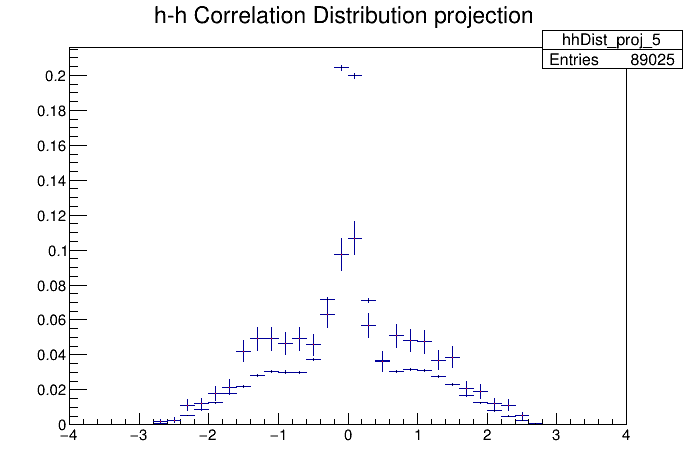

In [ ]:
dEta2.Draw()

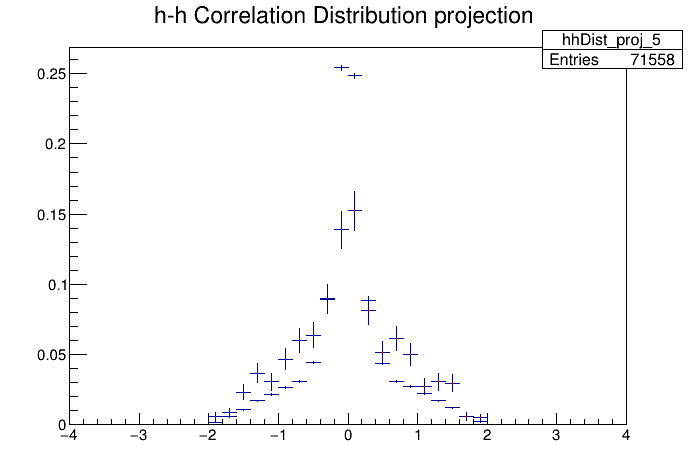

In [ ]:
dEta12.Draw()

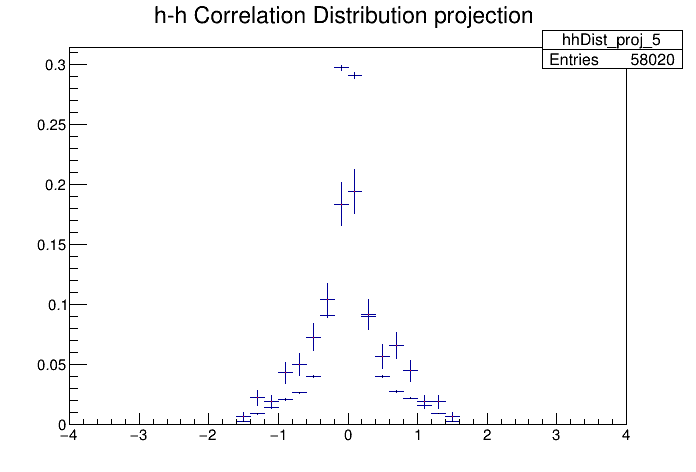

In [ ]:
dEta08.Draw()

## $\Delta \varphi$ Distributions

In [ ]:
def make_delta_phi_plots(sparse1, sparse2, ptTrig, ptAssoc, etaTrig, etaAssoc):
# why no pT cuts??????
    ptTrigMin, ptTrigMax = ptTrig
    ptAssocMin, ptAssocMax = ptAssoc
    etaTrigMin, etaTrigMax = etaTrig

    sparse1.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
    sparse1.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)

    sparse2.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
    sparse2.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)
    
    sparse1.GetAxis(axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)
    sparse2.GetAxis(axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)

    # iterate over eta cuts
    sparse1DPhiDists = []
    sparse2DPhiDists = []
    for etaAssocMin, etaAssocMax in etaAssoc:
        # apply eta cuts
        sparse1.GetAxis(axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)
        sparse2.GetAxis(axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)  

        dPhi1 = sparse1.Projection(axis['delta phi'])
        dPhi2 = sparse2.Projection(axis['delta phi'])
        
        sparse1DPhiDists.append(dPhi1)
        sparse2DPhiDists.append(dPhi2)

    # reset dist axes
    sparse1.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)
    sparse1.GetAxis(axis['associate pT']).SetRangeUser(0, 0)

    sparse2.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['associate pT']).SetRangeUser(0, 0)

    sparse1.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
    sparse1.GetAxis(axis['associate eta']).SetRangeUser(0, 0)

    sparse2.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['associate eta']).SetRangeUser(0, 0)

    return sparse1DPhiDists, sparse2DPhiDists

In [ ]:
hhDPhiDists, hlDPhiDists = make_delta_phi_plots(hhDist, hlDist, ptTrig=ptTrig, ptAssoc=ptAssoc, etaTrig=etaTrig, etaAssoc=eta)

Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4 (Potential memory leak).


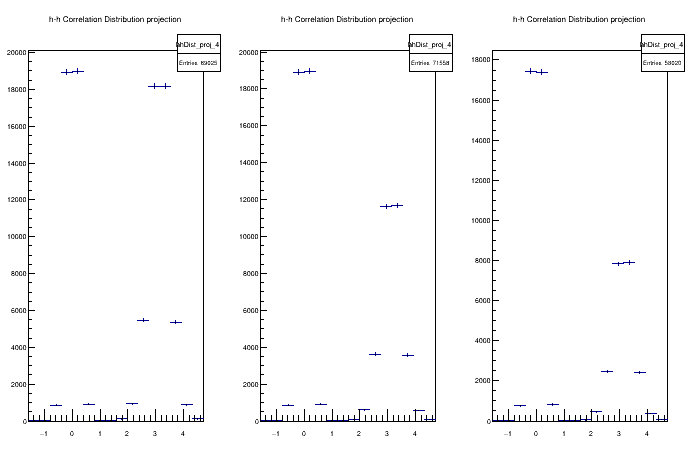

In [ ]:
hhDPhiCanvas = TCanvas()
hhDPhiCanvas.Divide(3, 1)
for i in range(1, 4):
    dist = hhDPhiDists[i-1]
    hhDPhiCanvas.cd(i)
    dist.Draw()

hhDPhiCanvas.Draw()

# Single Particle Distributions

# Code Snippets

In [ ]:
""" 
# get projections
# write projections
# close written file
# reaccess 

def sparse_to_temp_file(sparse):
    '''
    Writes 2D correlations and 1D correlations to a temp file. Keeps the file w/in local scope, so we can safely open it later.

    Args:
        sparse: THnSparse object
    '''
    dPhiDEta = sparse.Projection(5, 4)
    dPhi = sparse.Projection(5)
    dEta = sparse.Projection(4)

    tempFile = rt.TFile.Open('tempFile.root', 'RECREATE')
    tempFile.WriteObject(dPhiDEta, 'dPhiDEta')
    tempFile.WriteObject(dPhi, 'dPhi')
    tempFile.WriteObject(dEta, 'dEta') """

" \n# get projections\n# write projections\n# close written file\n# reaccess \n\ndef sparse_to_temp_file(sparse):\n    '''\n    Writes 2D correlations and 1D correlations to a temp file. Keeps the file w/in local scope, so we can safely open it later.\n\n    Args:\n        sparse: THnSparse object\n    '''\n    dPhiDEta = sparse.Projection(5, 4)\n    dPhi = sparse.Projection(5)\n    dEta = sparse.Projection(4)\n\n    tempFile = rt.TFile.Open('tempFile.root', 'RECREATE')\n    tempFile.WriteObject(dPhiDEta, 'dPhiDEta')\n    tempFile.WriteObject(dPhi, 'dPhi')\n    tempFile.WriteObject(dEta, 'dEta') "

In [ ]:
""" sparse_to_temp_file(hhDist)

file = uproot.open('tempFile.root')

dPhiDEta, x_edges, y_edges = file['dPhiDEta'].to_numpy()
dPhi, dPhi_edges = file['dPhi'].to_numpy()
dEta, dEta_edges = file['dEta'].to_numpy() """

" sparse_to_temp_file(hhDist)\n\nfile = uproot.open('tempFile.root')\n\ndPhiDEta, x_edges, y_edges = file['dPhiDEta'].to_numpy()\ndPhi, dPhi_edges = file['dPhi'].to_numpy()\ndEta, dEta_edges = file['dEta'].to_numpy() "

In [ ]:
""" # https://stackoverflow.com/questions/40200070/what-does-axis-0-do-in-numpys-sum-function
testPhi = np.sum(dPhiDEta, axis=0)
testEta = np.sum(dPhiDEta, axis=1) """

' # https://stackoverflow.com/questions/40200070/what-does-axis-0-do-in-numpys-sum-function\ntestPhi = np.sum(dPhiDEta, axis=0)\ntestEta = np.sum(dPhiDEta, axis=1) '

In [ ]:
""" fig, axs = plt.subplots(1, 3)

axs[0].stairs(testPhi, y_edges)
axs[1].stairs(testEta, x_edges)
axs[2].imshow(dPhiDEta.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]) """

" fig, axs = plt.subplots(1, 3)\n\naxs[0].stairs(testPhi, y_edges)\naxs[1].stairs(testEta, x_edges)\naxs[2].imshow(dPhiDEta.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]) "

In [ ]:
""" # Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.imshow(dPhiDEta.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
ax_histx.hist(testPhi, bins=y_edges)
ax_histy.hist(testEta, bins=x_edges, orientation='horizontal') """

" # Start with a square Figure.\nfig = plt.figure(figsize=(6, 6))\n# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between\n# the size of the marginal axes and the main axes in both directions.\n# Also adjust the subplot parameters for a square plot.\ngs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),\n                      left=0.1, right=0.9, bottom=0.1, top=0.9,\n                      wspace=0.05, hspace=0.05)\n# Create the Axes.\nax = fig.add_subplot(gs[1, 0])\nax_histx = fig.add_subplot(gs[0, 0], sharex=ax)\nax_histy = fig.add_subplot(gs[1, 1], sharey=ax)\n\nax.imshow(dPhiDEta.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])\nax_histx.hist(testPhi, bins=y_edges)\nax_histy.hist(testEta, bins=x_edges, orientation='horizontal') "

In [ ]:
""" def sparse_to_uproot(sparse):
    '''
    Takes THnSparse and returns a 2D correlation with projections into eta and phi.
    '''




    
     

 """

" def sparse_to_uproot(sparse):\n    '''\n    Takes THnSparse and returns a 2D correlation with projections into eta and phi.\n    '''\n\n\n\n\n    \n     \n\n "

In [ ]:
""" file = uproot.open('testFile.root') """

" file = uproot.open('testFile.root') "

In [ ]:
""" file.keys() """

' file.keys() '

In [ ]:
""" # https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html
myhist, xedges, yedges= file['myhist'].to_numpy()

fig, ax = plt.subplots()
plt.imshow(myhist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]) """

" # https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html\nmyhist, xedges, yedges= file['myhist'].to_numpy()\n\nfig, ax = plt.subplots()\nplt.imshow(myhist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]) "

In [ ]:
""" # https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html



fig = plt.figure()
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax.set(aspect=1)

ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)


 """

' # https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html\n\n\n\nfig = plt.figure()\nax = fig.add_gridspec(top=0.75, right=0.75).subplots()\nax.set(aspect=1)\n\nax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)\nax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)\n\n\n '